# **RESEARCH ASSIGNMENT-3:**

**IMPORT LIBRARIES:**

In [132]:
# =========================
# System & Utilities
# =========================
import os
import time
import datetime
import zipfile
import requests
import warnings
from collections import Counter, defaultdict
from packaging import version

# Suppress warnings
warnings.filterwarnings("ignore")

# =========================
# Data Handling
# =========================
import numpy as np
import pandas as pd

# Display Settings
np.set_printoptions(precision=3, suppress=True)

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

# =========================
# Scikit-learn
# =========================
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss,
    mean_squared_error as MSE
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

# =========================
# Natural Language Processing (NLP)
# =========================
import nltk
from nltk.corpus import stopwords

# =========================
# TensorFlow / Keras
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Embedding, 
    SimpleRNN, LSTM, GRU, Bidirectional, 
    Conv1D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as k

# =========================
# TensorFlow Datasets
# =========================
import tensorflow_datasets as tfds


**TENSORFLOW VERSION:**

In [2]:
print("Minimum Tensorflow version requirement of Research Assignment-1 is 2.0 or above")
print("Tensorflow Version: ",tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

Minimum Tensorflow version requirement of Research Assignment-1 is 2.0 or above
Tensorflow Version:  2.18.0


**LOADING DATASET:**

The ag_news_dataset is downloaded from Tensorflow datasets (TFDS), is a benchmark dataset used for text classification tasks. It consists of short news articles categorized into 4 classes: World, Sports, Business, and Sci/Tech.

+ Training Samples : 120,000
+ Testing Samples  : 7,600

Features:
+ Text : A string containing the news article (title & description)
+ label : An integer from 0 to 3 representing each category.

In [31]:
# Load AG News dataset
ds_train, ds_test = tfds.load('ag_news_subset', split=['train', 'test'], as_supervised=True)

train_data = [(text.numpy().decode('utf-8'), label.numpy()) for text, label in ds_train]

df_train = pd.DataFrame(train_data, columns=['text', 'label'])

# Class Names:
builder = tfds.builder('ag_news_subset')
builder.download_and_prepare()
label_names = builder.info.features['label'].names
df_train['label_name'] = df_train['label'].apply(lambda x: label_names[x])

# Class Distribution:
print("Number of classes:", len(label_names))
print("Class names:", label_names)
print("\nDocuments per class:")
print(df_train['label_name'].value_counts())

Number of classes: 4
Class names: ['World', 'Sports', 'Business', 'Sci/Tech']

Documents per class:
label_name
Sci/Tech    30000
Sports      30000
Business    30000
World       30000
Name: count, dtype: int64


In [138]:
df_train.head()

text  label label_name  \
0  AMD #39;s new dual-core Opteron chip is design...      3   Sci/Tech   
1  Reuters - Major League Baseball\Monday announc...      1     Sports   
2  President Bush #39;s  quot;revenue-neutral quo...      2   Business   
3  Britain will run out of leading scientists unl...      3   Sci/Tech   
4  London, England (Sports Network) - England mid...      1     Sports   

   doc_length                                       cleaned_text  
0          20  amd #39;s new dual-core opteron chip designed ...  
1          26  reuters - major league baseball\monday announc...  
2          34  president bush #39;s quot;revenue-neutral quot...  
3          16  britain run leading scientists unless science ...  
4          33  london, england (sports network) - england mid...

Glance at the Test Split:

In [69]:
test_data = [(text.numpy().decode('utf-8'), label.numpy()) for text, label in ds_test]
df_test = pd.DataFrame(test_data, columns=['text', 'label'])
builder = tfds.builder('ag_news_subset')
builder.download_and_prepare()
label_names = builder.info.features['label'].names
df_test['label_name'] = df_test['label'].apply(lambda x: label_names[x])

print("Number of classes:", len(label_names))
print("Class names:", label_names)
print("\nDocuments per class:")
print(df_test['label_name'].value_counts())

Number of classes: 4
Class names: ['World', 'Sports', 'Business', 'Sci/Tech']

Documents per class:
label_name
Sports      1900
World       1900
Sci/Tech    1900
Business    1900
Name: count, dtype: int64


Class Distribution and Text Lengths

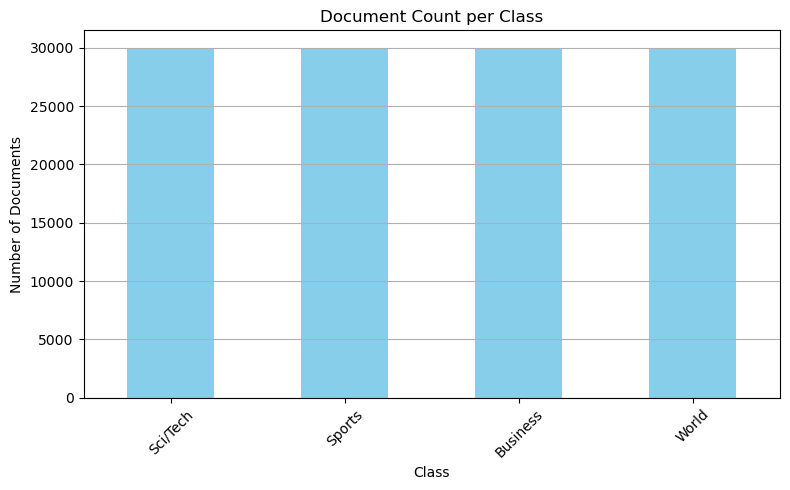

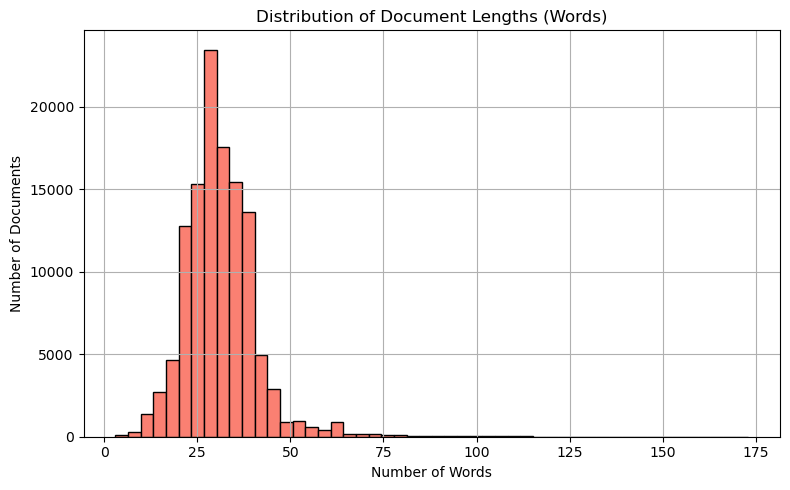

Max document length: 173
Average document length: 31.06
Median document length: 30.0


In [32]:
plt.figure(figsize=(8, 5))
df_train['label_name'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Document Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Document Length Distribution (in words) :
df_train['doc_length'] = df_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
plt.hist(df_train['doc_length'], bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Document Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary Stats:
print(f"Max document length: {df_train['doc_length'].max()}")
print(f"Average document length: {df_train['doc_length'].mean():.2f}")
print(f"Median document length: {df_train['doc_length'].median()}")


The distribution of document lengths in the AG News dataset is characterized by a strong right skew. A large proportion of the news articles are short, typically containing between 20 and 40 words. While there are some longer articles, their frequency diminishes as the word count increases, resulting in a long right tail in the distribution. This suggests that for many news items in this dataset, the core information is conveyed succinctly with an average document length of 31 words.

#### **1.1 Vocabulary Size Experimentation**

Top 10 most frequent words for each vocabulary size

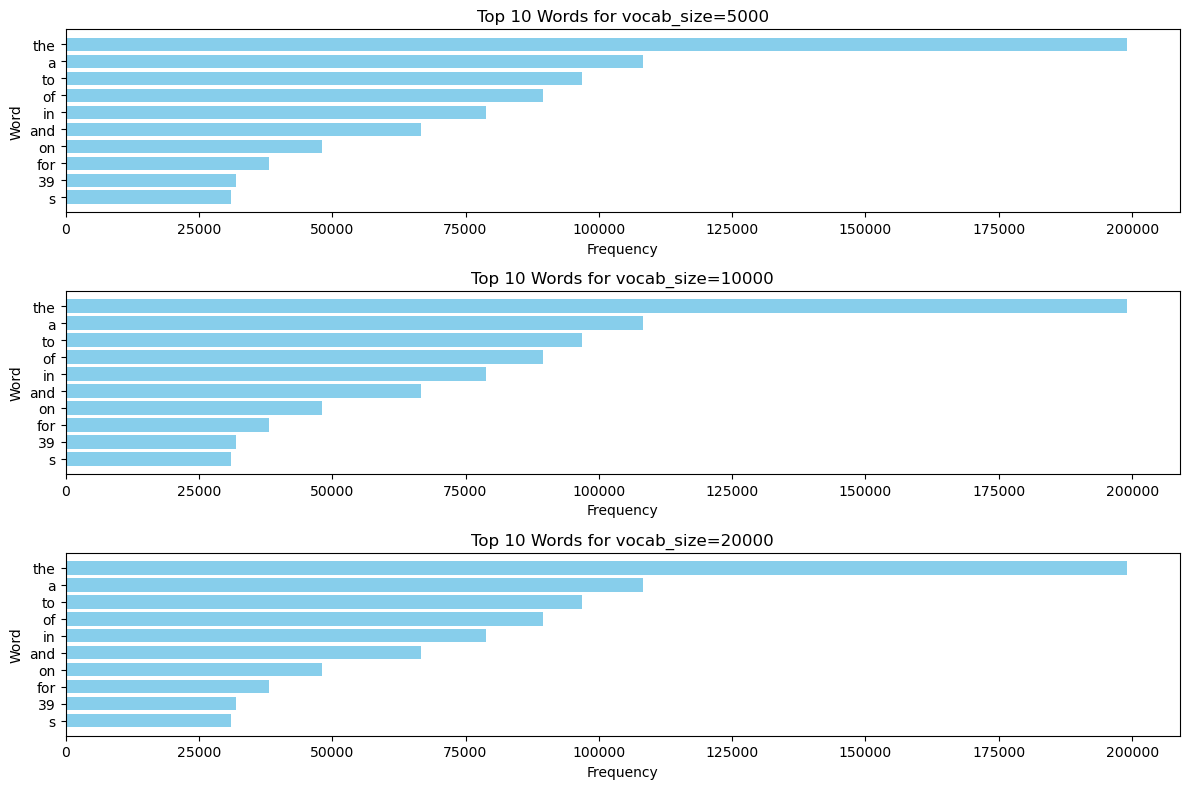

In [33]:
# Experiment: 3 levels of vocab sizes
vocab_sizes = [5000, 10000, 20000]
tokenizer_stats = {}

plt.figure(figsize=(12, 8))

for vocab_size in vocab_sizes:
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(df_train['text'])

    word_counts = tokenizer.word_counts
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    
    tokenizer_stats[vocab_size] = sorted_counts

    df_top_words = pd.DataFrame(sorted_counts, columns=["Word", "Frequency"])

    # Plot: The top 10 words for a vocabulary size
    plt.subplot(3, 1, vocab_sizes.index(vocab_size) + 1)
    plt.barh(df_top_words['Word'], df_top_words['Frequency'], color='skyblue')
    plt.title(f"Top 10 Words for vocab_size={vocab_size}")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.gca().invert_yaxis()  

plt.tight_layout()  
plt.show()


The top 10 most frequent words in the AG News dataset, regardless of the vocabulary size (5000, 10000, or 20000), are heavily dominated by common stop words such as "the," "a," "to," "of," "in," "and," and "on." Additionally, the numerical token "39" consistently appears among the top words. This indicates that these high-frequency words are prevalent throughout the news articles in the dataset. The relative order and frequency of these top words remain fairly stable even as the total vocabulary size increases. This observation highlights the importance of considering stop word removal as a preprocessing step to focus on more informative words.

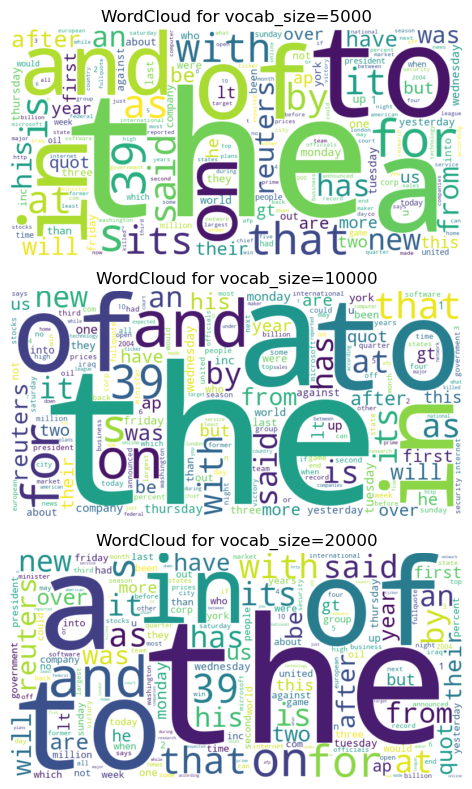

In [ ]:
plt.figure(figsize=(12, 8))

for vocab_size in vocab_sizes:
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(df_train['text'])

    word_counts = tokenizer.word_counts
    
    # Word cloud:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

    # Subplots for each vocab size:
    plt.subplot(3, 1, vocab_sizes.index(vocab_size) + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for vocab_size={vocab_size}")

plt.tight_layout() 
plt.show()


The word clouds visually confirm that the most frequent words in the AG News dataset are primarily common stop words, regardless of the vocabulary size. These stop words appear significantly larger due to their high frequency. The numerical token "39" also stands out. As the vocabulary size increases from 5000 to 20000, we observe a gradual emergence of other, potentially more content-rich words becoming more prominent in the word cloud, indicating their higher frequency within the expanded vocabulary. However, the dominance of stop words remains a key characteristic across all vocabulary sizes visualized.

#### **1.2 Vocabulary Filtering (Stop Word Removal)**

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ek_36\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 Words (Unedited Vocabulary):
<OOV>: 1
the: 2
a: 3
to: 4
of: 5
in: 6
and: 7
on: 8
for: 9
39: 10

Top 10 Words (Edited Vocabulary - Stopwords Removed):
<OOV>: 1
39: 2
s: 3
said: 4
new: 5
reuters: 6
two: 7
us: 8
quot: 9
year: 10


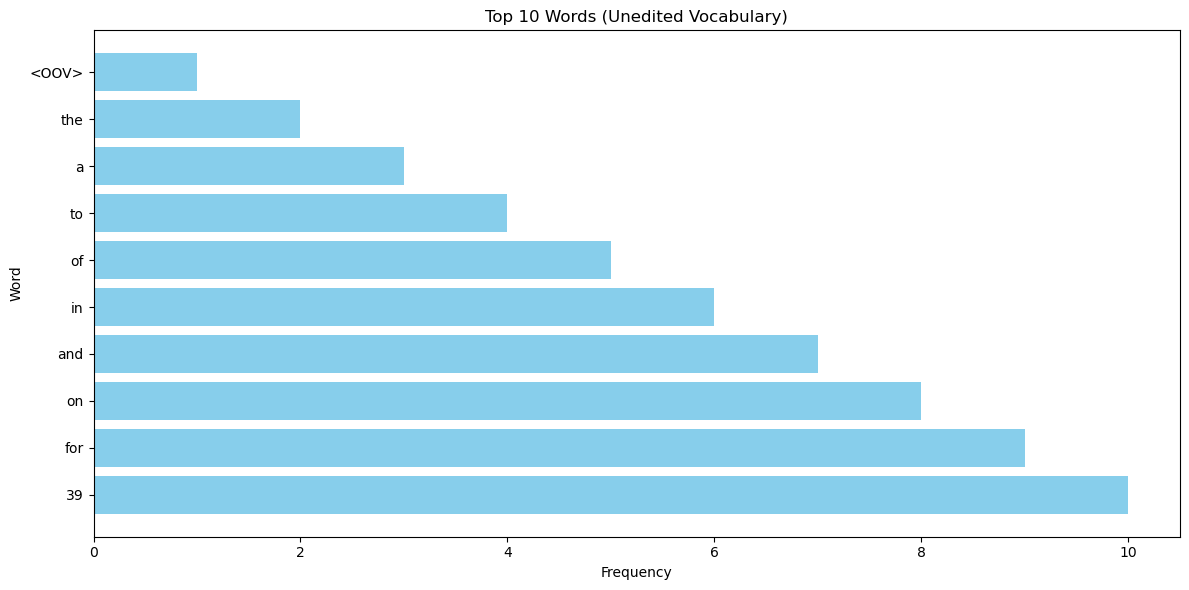

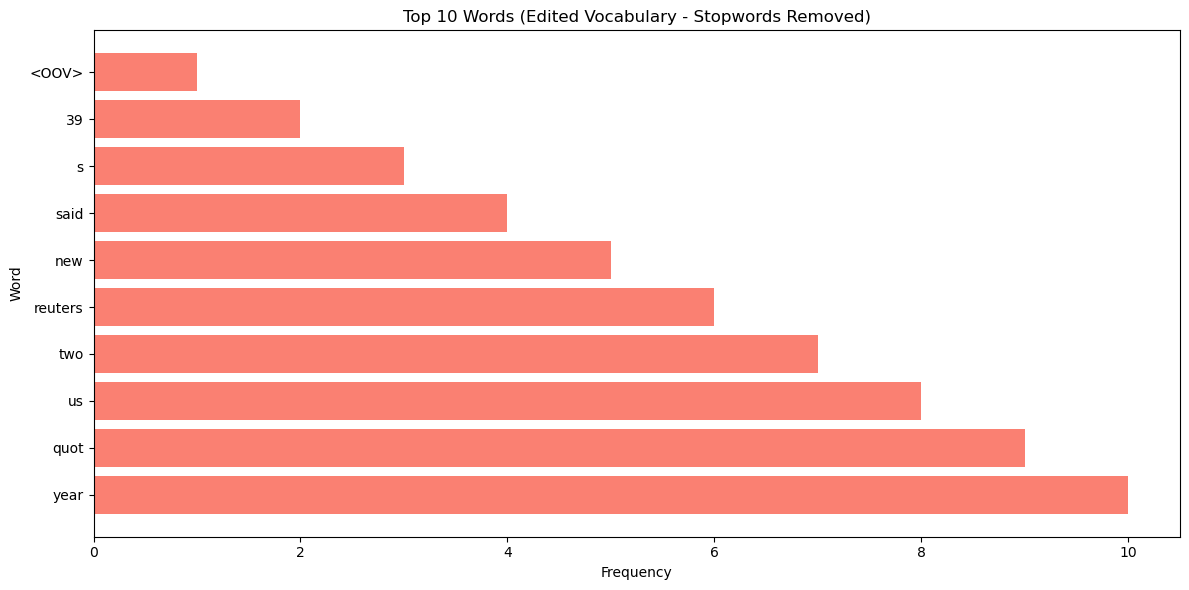

In [36]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Function: clean text (removing stopwords)
def remove_stopwords(text):
    return ' '.join([word for word in text.lower().split() if word not in stop_words])

df_train['cleaned_text'] = df_train['text'].apply(remove_stopwords)


# TOKENIZER for BOTH VOCABULARIES:
# Unedited Tokenizer (no stopwords removed)
tokenizer_unedited = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer_unedited.fit_on_texts(df_train['text'])

# Edited Tokenizer (stopwords removed)
tokenizer_edited = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer_edited.fit_on_texts(df_train['cleaned_text'])

#Most Frequent Words for each tokenizer (Top 10 most frequent words for Edited & Unedited Vocabs)
top_words_unedited = list(tokenizer_unedited.word_index.items())[:10]
top_words_edited = list(tokenizer_edited.word_index.items())[:10]


print("Top 10 Words (Unedited Vocabulary):")
for word, count in top_words_unedited:
    print(f"{word}: {count}")

print("\nTop 10 Words (Edited Vocabulary - Stopwords Removed):")
for word, count in top_words_edited:
    print(f"{word}: {count}")

# VISUALIZATION:
# Bar chart for top words (unedited)
top_words_unedited_df = pd.DataFrame(top_words_unedited, columns=["Word", "Frequency"])

# Bar chart for top words (edited)
top_words_edited_df = pd.DataFrame(top_words_edited, columns=["Word", "Frequency"])

# Plot Unedited vocabulary
plt.figure(figsize=(12, 6))
plt.barh(top_words_unedited_df['Word'], top_words_unedited_df['Frequency'], color='skyblue')
plt.title("Top 10 Words (Unedited Vocabulary)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot Edited vocabulary
plt.figure(figsize=(12, 6))
plt.barh(top_words_edited_df['Word'], top_words_edited_df['Frequency'], color='salmon')
plt.title("Top 10 Words (Edited Vocabulary - Stopwords Removed)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


The comparison of the two bar charts clearly demonstrates the impact of stop word removal on the most frequent words in the AG News dataset. Before removing stop words, the top words are dominated by common grammatical terms that offer little specific information about the content. However, after removing stop words, the top 10 list shifts to include words like "year," "quot," "us," and "said," which are more likely to be indicative of the topics and content discussed in the news articles. This highlights the importance of stop word removal as a crucial preprocessing step in natural language processing to focus on more meaningful and informative terms. The persistent presence of "39" and "&lt;OOV>" suggests these tokens have a relatively high frequency even after stop word filtering.

##### 1.2.1 EDA: Word Distribution by Class (After Stopword Removal)

In [27]:
# Filtered documents by their label:
class_texts = defaultdict(list)
for doc, label in zip(filtered_texts, labels):
    class_texts[label].append(doc)

class_word_counts = {}

for label, docs in class_texts.items():
    all_words = ' '.join(docs).split()
    word_freq = Counter(all_words)
    class_word_counts[label] = word_freq


# Top 10 words per class:
for label in sorted(class_word_counts.keys()):
    print(f"\nTop words in Class {label}:")
    for word, count in class_word_counts[label].most_common(10):
        print(f"{word}: {count}")



Top words in Class 0:
-: 13326
said: 5408
#39;s: 5190
president: 3652
two: 2895
minister: 2867
ap: 2768
new: 2603
(reuters): 2478
iraq: 2466

Top words in Class 1:
-: 8245
#39;s: 7593
new: 3533
first: 3441
ap: 3100
last: 2622
--: 2513
world: 2460
two: 2409
team: 2328

Top words in Class 2:
-: 8851
#39;s: 7258
said: 6607
new: 5714
(reuters): 4296
oil: 3953
us: 3809
inc.: 3515
company: 3133
york: 2986

Top words in Class 3:
-: 7606
new: 5222
#39;s: 4959
said: 3199
microsoft: 2766
software: 2646
internet: 2324
company: 2210
--: 1839
computer: 1786


#### **1.3 Output Sequence Length Experimentation**

In [ ]:
# Function: Padding/Truncating Texts

def pad_truncate_sequences(texts, max_len):
    # Tokenization:
    tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    
    # Text to sequences:
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad/truncate:
    padded_sequences = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_len)
    
    return padded_sequences, tokenizer


##### 1.3.1 Default vs. Fixed Sequence Lengths (128 tokens)

In [38]:
# Default Sequence Length (no truncation)
default_sequences, tokenizer_default = pad_truncate_sequences(df_train['text'], max_len=None)  
print(f"Default sequence length: {default_sequences.shape[1]}")

# Fixed Sequence Length (128 tokens)
fixed_len = 128
fixed_sequences, tokenizer_fixed = pad_truncate_sequences(df_train['text'], max_len=fixed_len)
print(f"Fixed sequence length: {fixed_sequences.shape[1]}")


Default sequence length: 173
Fixed sequence length: 128


##### 1.3.2 Visualize Sequence Length Distribution

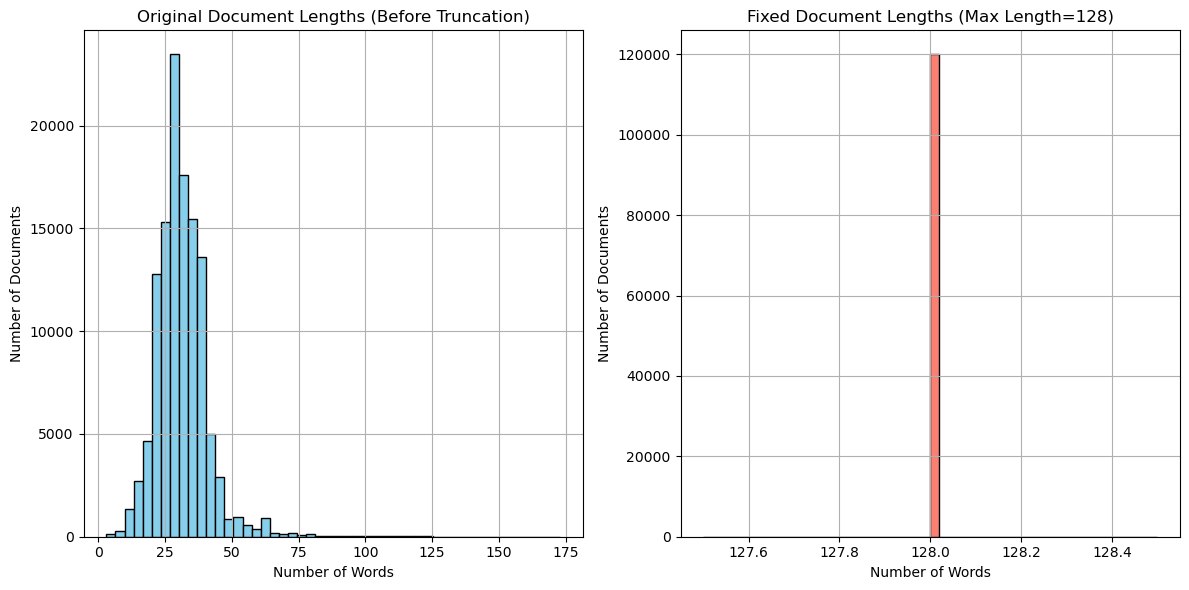

In [39]:
# Original Document Lengths (before truncation)
original_lengths = [len(doc.split()) for doc in df_train['text']]

# Document Lengths After Truncation (to fixed length)
fixed_lengths = [len(seq) for seq in fixed_sequences]

# Plot both distributions
plt.figure(figsize=(12, 6))

# Original document lengths
plt.subplot(1, 2, 1)
plt.hist(original_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Original Document Lengths (Before Truncation)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.grid(True)

# Fixed document lengths after truncation
plt.subplot(1, 2, 2)
plt.hist(fixed_lengths, bins=50, color='salmon', edgecolor='black')
plt.title(f"Fixed Document Lengths (Max Length={fixed_len})")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.grid(True)

plt.tight_layout()
plt.show()


The left histogram illustrates the original distribution of document lengths, showing a wide range with a skew towards shorter documents. The right histogram demonstrates the effect of applying sequence length truncation with a maximum length of 128 words. After truncation (and likely padding for shorter sequences, though not directly shown), the document lengths are fixed at the specified maximum length. This results in a distribution where almost all documents have exactly 128 words, as indicated by the single, very tall bar at that word count. This standardization of sequence length is a common preprocessing step in natural language processing, particularly for models that require fixed-size input.

#### **1.4 Baseline DNN for Comparison Across Preprocessing Settings**

Variables to test:
+ Vocabulary Size: 5000, 10000, 20000
+ Stopword Removal: Yes vs No
+ Sequence Length: None (natural) vs 128 (fixed)

Let's create a simple dense neural network (DNN) classifier and run 12 total configurations:  
   + 3 vocab sizes × 2 stopword settings × 2 sequence lengths = 12 total experiments.



**Baseline Model Configuration**
+ Model: Simple Dense Neural Network
+ Epochs: 20
+ Batch size: 100
+ Optimizer: Adam
+ Loss: sparse_categorical_crossentropy
+ Metrics: accuracy

Creating some functions to utilise it across all 12 combinations of experiment setup to determine the stable variable values to test on other subsequent experiements.

In [ ]:
# Preprocessing Functions:
def preprocess_texts(texts, vocab_size, remove_stopwords=False):
    if remove_stopwords:
        texts = [' '.join([word for word in text.lower().split() if word not in stop_words]) for text in texts]
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return sequences, tokenizer


# Padding Function:
def pad_texts(sequences, max_len=None):
    return pad_sequences(sequences, padding='post', truncating='post', maxlen=max_len)


Dataset was previously divided into train and test dataset. Now for the fitting and testing purpose we allocate subset of train dataset as validation dataset. 

Now,
+ df_train_model, 
+ df_val_model, and 
+ df_test 

are used for modeling.

In [ ]:
df_modeling = df_train.copy()

# Training & Validation split:
df_train_model, df_val_model = train_test_split(
    df_modeling,
    test_size=0.2,
    stratify=df_modeling['label'],
    random_state=369
)

raw_train_texts = df_train_model['text'].tolist()
train_labels = df_train_model['label'].values
raw_val_texts = df_val_model['text'].tolist()
val_labels = df_val_model['label'].values


##### 1.4.1 Glove Pre-Trained Embedding Model: 

Pre-trained Glove model is used to represent the tokenized text into vector embeddings.

##### 1.4.1.1 Glove Model Download

In [42]:
# Download: GloVe embeddings:
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "glove.6B.zip"
glove_extract_dir = "glove.6B"

if not os.path.exists(glove_zip_path):
    response = requests.get(glove_url)
    with open(glove_zip_path, "wb") as f:
        f.write(response.content)

if not os.path.exists(glove_extract_dir):
    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_extract_dir)


print("Extracted files:", os.listdir(glove_extract_dir))


Extracted files: ['glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.6B.50d.txt']


##### 1.4.1.2 Load GloVe Vectors into a Dictionary

Glove.6B.200d.txt dictionary will be used.

In [43]:
# Load: GloVe 200D vectors
embedding_index = {}
with open("glove.6B/glove.6B.200d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")


Loaded 400000 word vectors from GloVe.


Experiment Function:

The function below is designed to experiment with the impact of different vocabulary sizes, stop word removal, and sequence lengths on the model's predictive performance with the training custome embeddings. Later with Experiment-C and Experiment D we utilise the pre trained embedding models like Glove for predictions.

In [108]:
def run_experiment(exp_num, vocab_size, remove_stopwords, fixed_seq_len, 
                   embedding_index, raw_train_texts, train_labels,
                   raw_val_texts, val_labels, embedding_dim=200,epochs=10):

    
    print(f"\n=========== Experiment-{exp_num} ===========")
    print(f"Vocab Size: {vocab_size}, Stopwords: {'Removed' if remove_stopwords else 'Kept'}, Sequence Length: {'Fixed(128)' if fixed_seq_len else 'Natural'}")

    start_time = time.time()

    # Stop Word Removal:
    stop_words = set(stopwords.words('english'))

    if remove_stopwords:
        train_texts = [' '.join([w for w in text.lower().split() if w not in stop_words]) for text in raw_train_texts]
        val_texts = [' '.join([w for w in text.lower().split() if w not in stop_words]) for text in raw_val_texts]
    else:
        train_texts = [text.lower() for text in raw_train_texts]
        val_texts = [text.lower() for text in raw_val_texts]

    # Tokenizer:
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_val_seq = tokenizer.texts_to_sequences(val_texts)

    if fixed_seq_len is not None:
        X_train = pad_sequences(X_train_seq, maxlen=fixed_seq_len, padding='post', truncating='post')
        X_val = pad_sequences(X_val_seq, maxlen=fixed_seq_len, padding='post', truncating='post')
        input_len = fixed_seq_len
    else:
        max_len = max([len(seq) for seq in X_train_seq])
        X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
        X_val = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
        input_len = max_len

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            vec = embedding_index.get(word)
            if vec is not None:
                embedding_matrix[i] = vec

    # Baseline DNN Model:
    model = Sequential([
        # Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
        #           input_length=input_len, trainable=False),

        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_len),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, train_labels, epochs=epochs, batch_size=100,
                        validation_data=(X_val, val_labels), verbose=0)

    # Predict
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    y_train_pred = np.argmax(model.predict(X_train), axis=1)

    # Model Evaluation:
    print("\n--- Train Classification Report ---")
    print(classification_report(train_labels, y_train_pred))

    print("\n--- Val Classification Report ---")
    print(classification_report(val_labels, y_val_pred))

    # Confusion matrices:
    def plot_confusion(cm, title):
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title)
        plt.ylabel('True')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()

    plot_confusion(confusion_matrix(train_labels, y_train_pred), f'Confusion Matrix - Train (Exp {exp_num})')
    plot_confusion(confusion_matrix(val_labels, y_val_pred), f'Confusion Matrix - Val (Exp {exp_num})')

    # Accuracy Vs Epochs Plot:
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy over Epochs - Exp {exp_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(ticks=range(epochs + 1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Loss Vs Epochs Plot:
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss over Epochs - Exp {exp_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(ticks=range(epochs + 1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    training_time = time.time() - start_time
    print(f"\nTraining time: {training_time:.2f} seconds")

    return {
        'Experiment': exp_num,
        'Vocab Size': vocab_size,
        'Stopwords Removed': remove_stopwords,
        'Sequence Length': 'Fixed(128)' if fixed_seq_len else 'Natural',
        'Train Accuracy': history.history['accuracy'][-1],
        'Val Accuracy': history.history['val_accuracy'][-1],
        'Train Loss': history.history['loss'][-1],
        'Val Loss': history.history['val_loss'][-1],
        'Training Time (s)': round(training_time, 2)
    }


Loop Through 12 Experiments:


=========== Experiment-1 ===========
Vocab Size: 5000, Stopwords: Kept, Sequence Length: Natural
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      6000
           1       0.94      0.96      0.95      6000
           2       0.87      0.81      0.84      6000
           3       0.84      0.85      0.85      6000

    accuracy                          

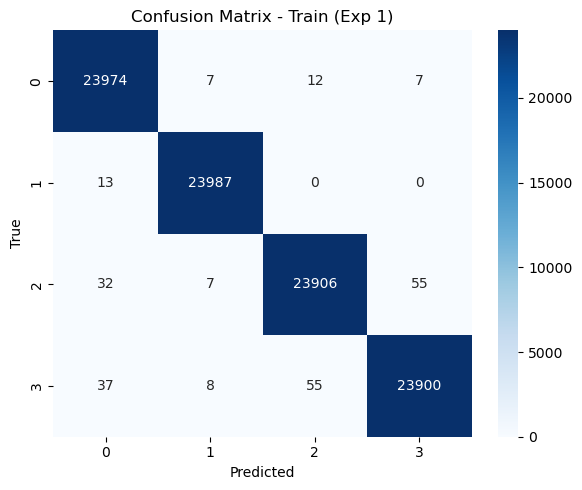

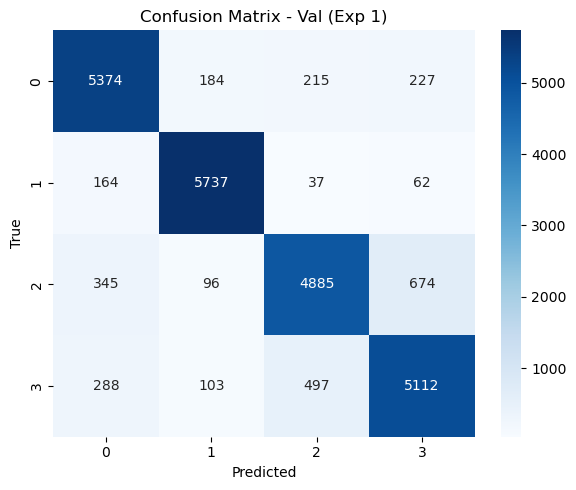

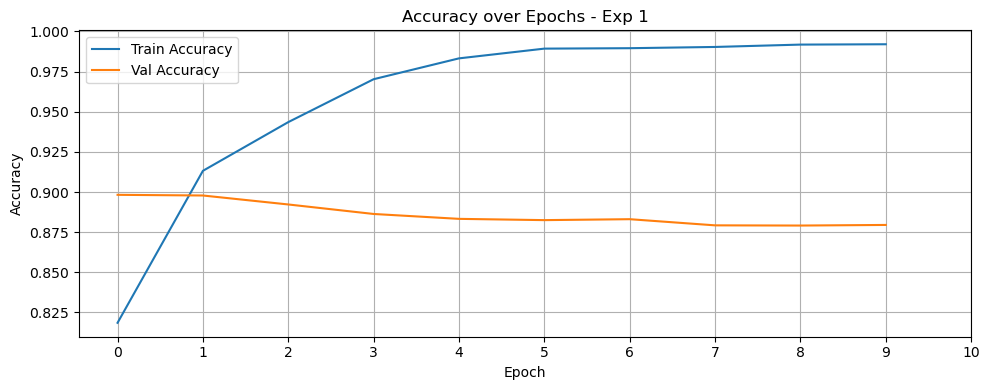

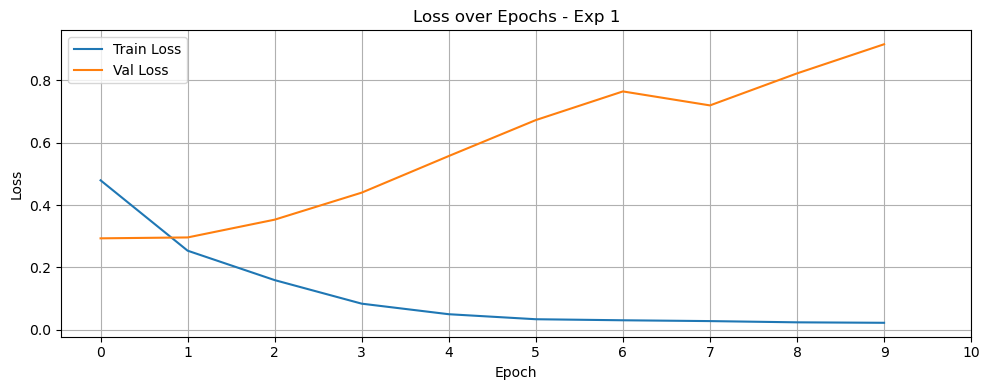


Training time: 211.93 seconds

=========== Experiment-2 ===========
Vocab Size: 5000, Stopwords: Kept, Sequence Length: Fixed(128)
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      6000
           1       0.94      0.96      0.95      6000
           2       0.83      0.85      0.84      6000
           3       0.85      0.84      0.84      6000

    a

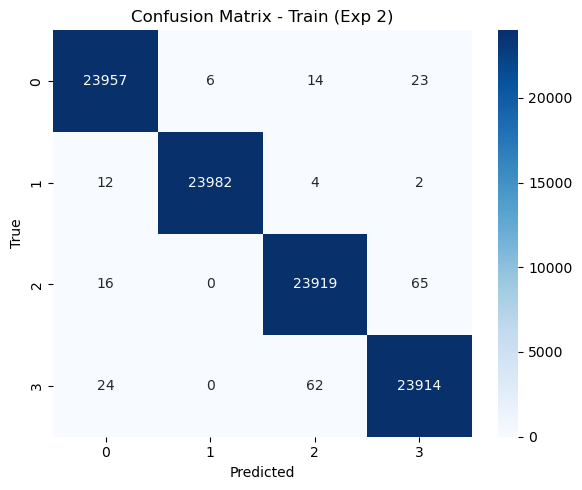

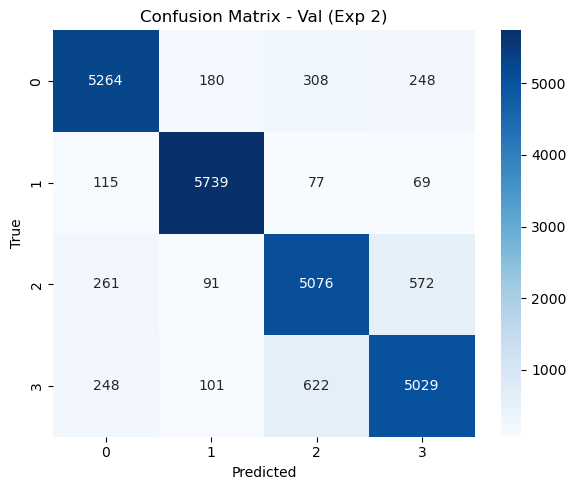

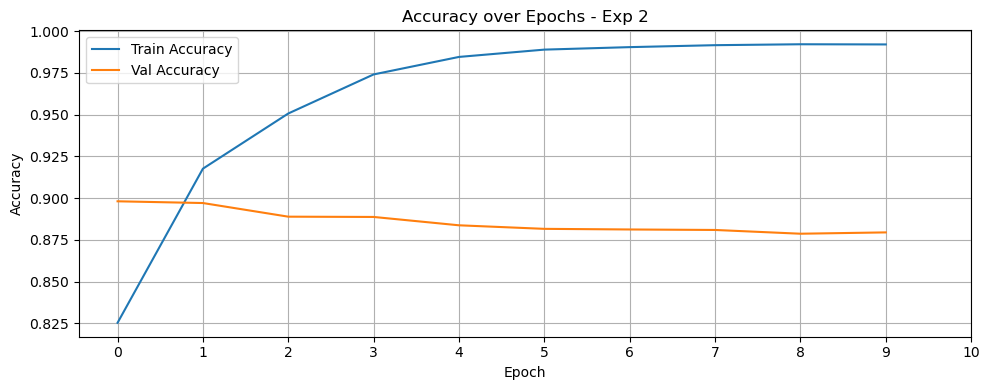

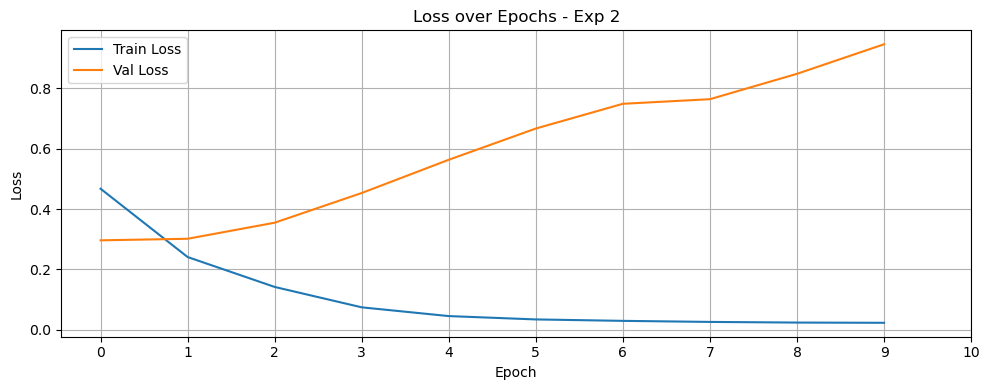


Training time: 166.50 seconds

=========== Experiment-3 ===========
Vocab Size: 5000, Stopwords: Removed, Sequence Length: Natural
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       0.99      1.00      1.00     24000
           3       1.00      0.99      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      6000
           1       0.94      0.96      0.95      6000
           2       0.80      0.87      0.83      6000
           3       0.86      0.81      0.83      6000

    

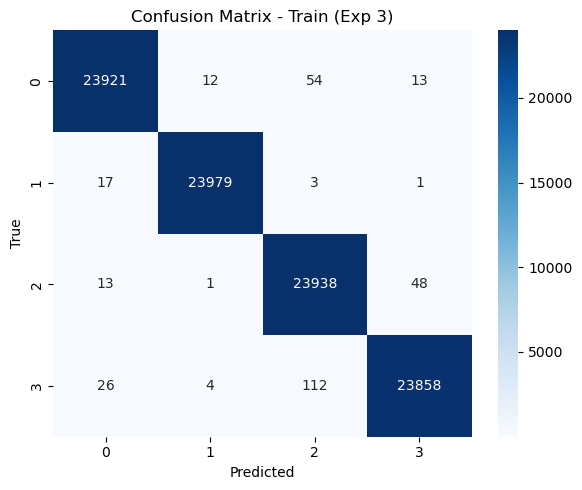

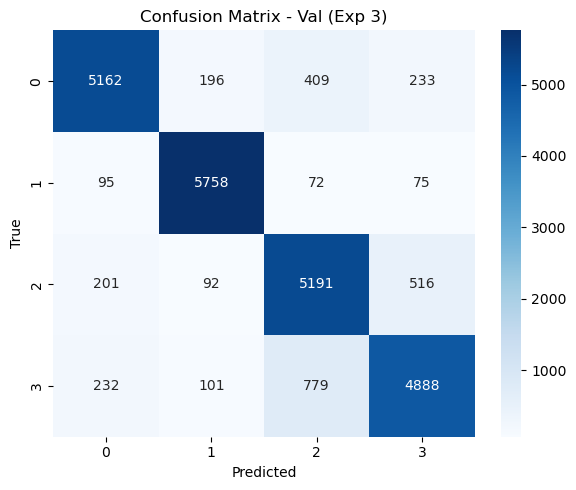

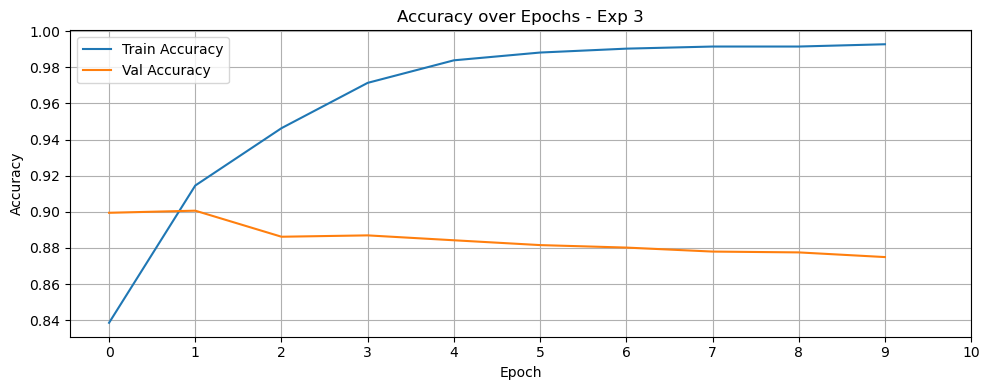

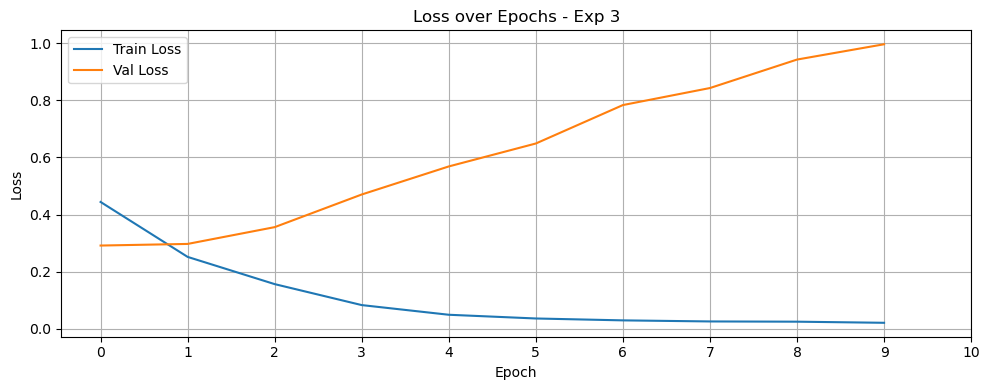


Training time: 189.31 seconds

=========== Experiment-4 ===========
Vocab Size: 5000, Stopwords: Removed, Sequence Length: Fixed(128)
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      6000
           1       0.92      0.96      0.94      6000
           2       0.84      0.84      0.84      6000
           3       0.86      0.82      0.84      6000

  

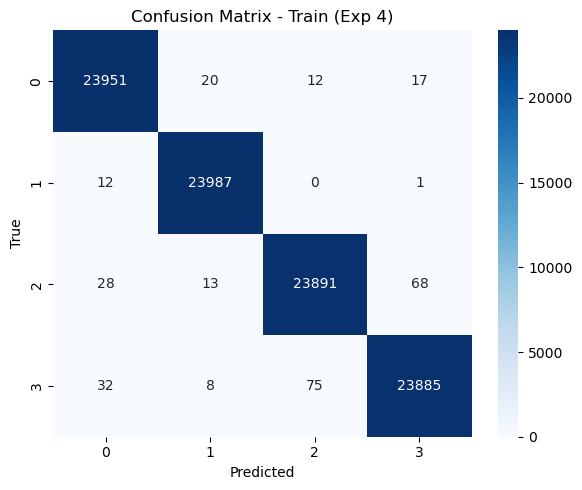

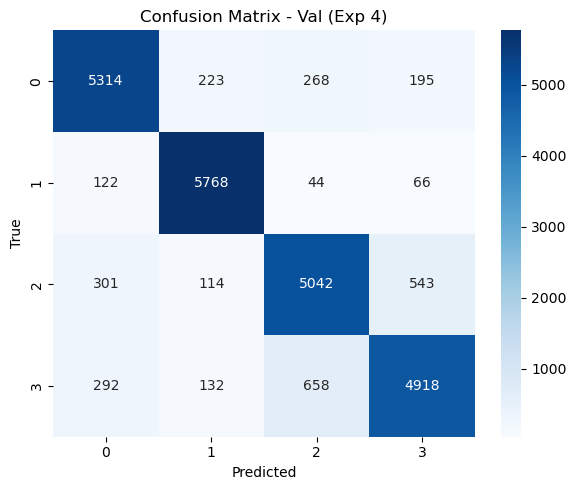

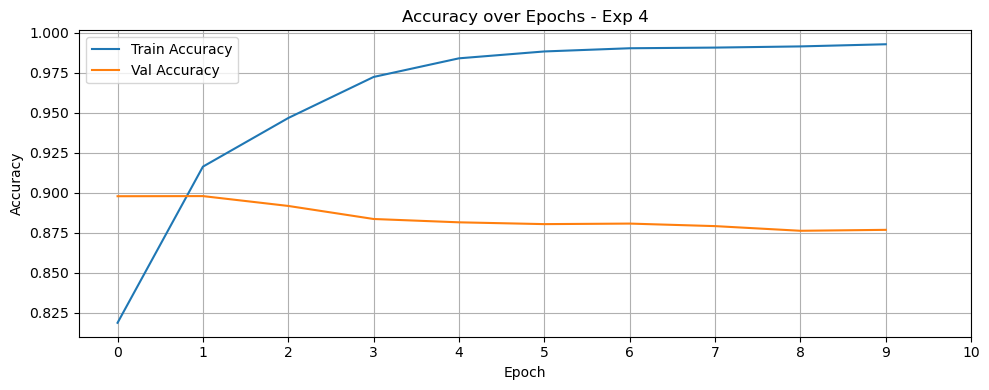

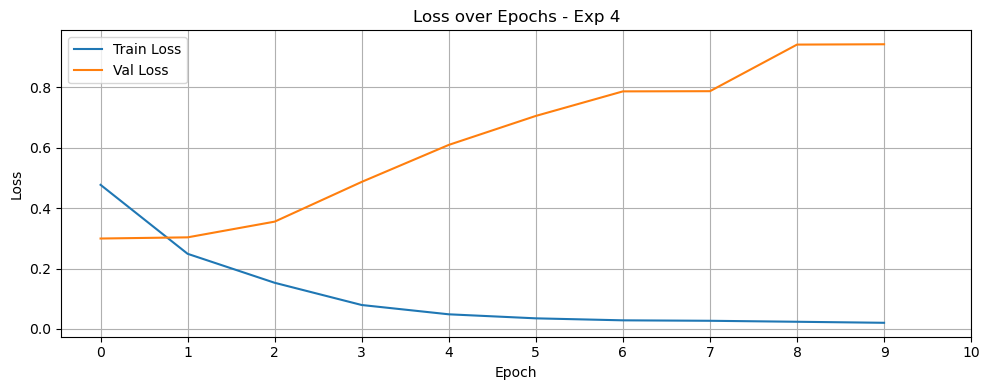


Training time: 167.23 seconds

=========== Experiment-5 ===========
Vocab Size: 10000, Stopwords: Kept, Sequence Length: Natural
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       0.99      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6000
           1       0.95      0.95      0.95      6000
           2       0.87      0.84      0.85      6000
           3       0.84      0.89      0.86      6000

    acc

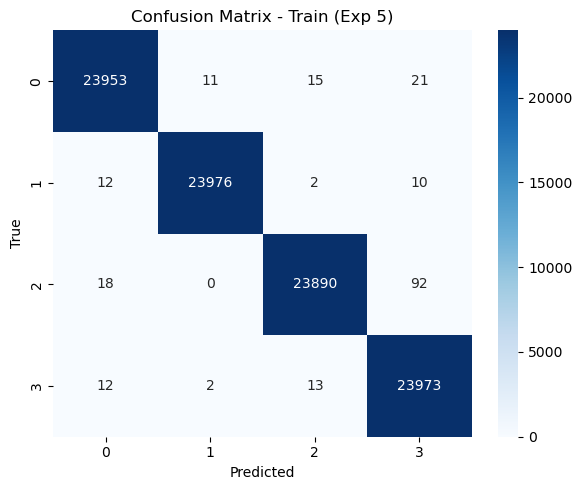

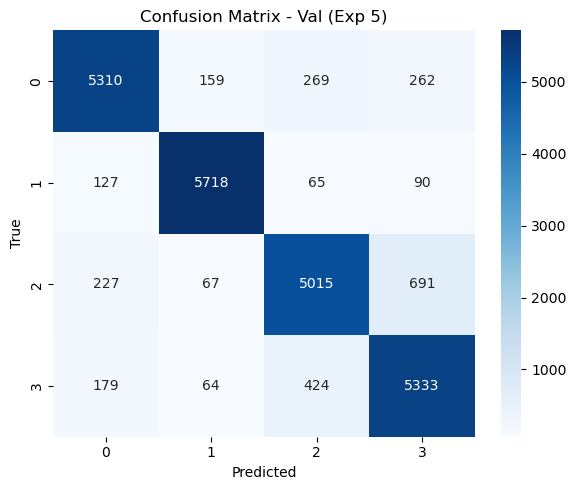

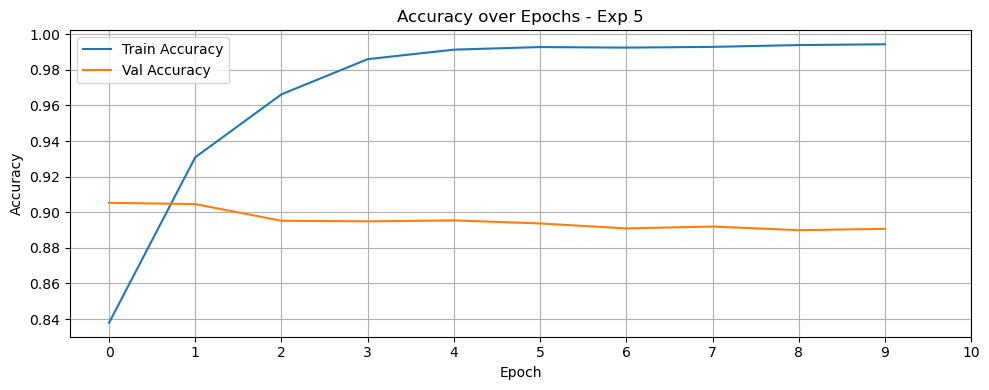

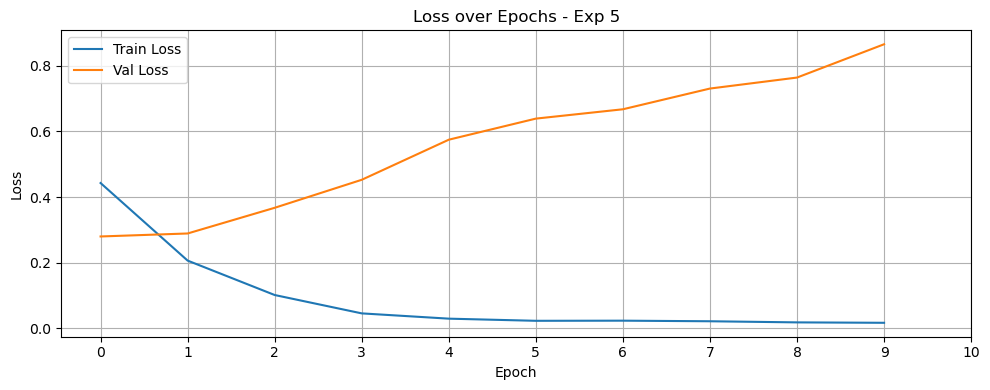


Training time: 182.17 seconds

=========== Experiment-6 ===========
Vocab Size: 10000, Stopwords: Kept, Sequence Length: Fixed(128)
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      6000
           1       0.94      0.96      0.95      6000
           2       0.86      0.84      0.85      6000
           3       0.85      0.86      0.86      6000

    

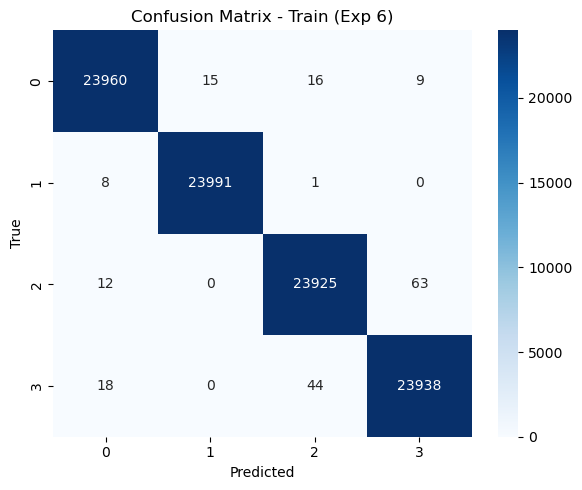

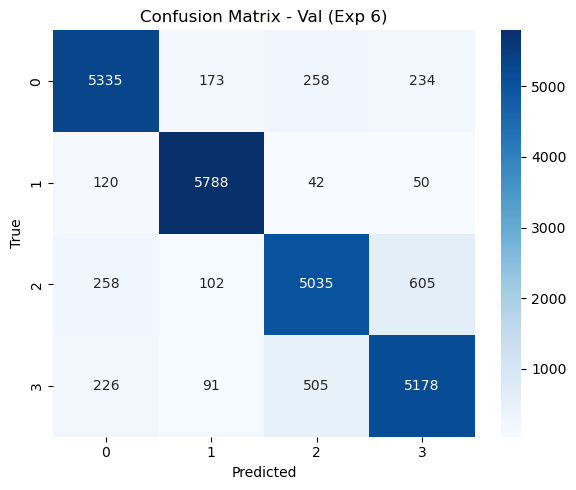

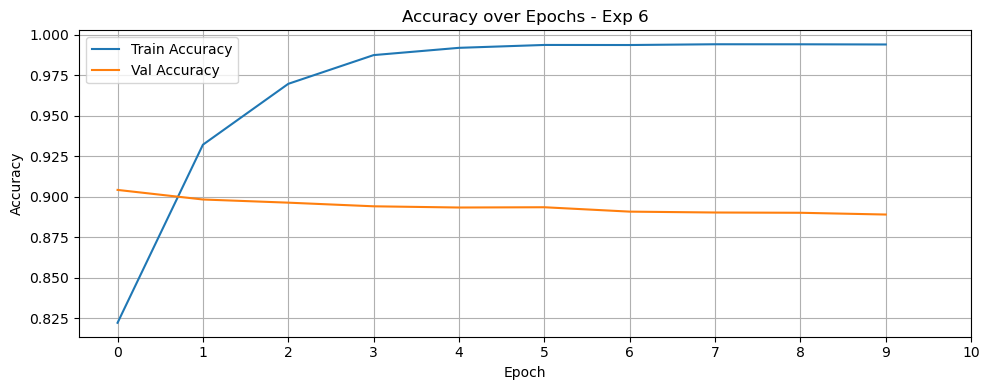

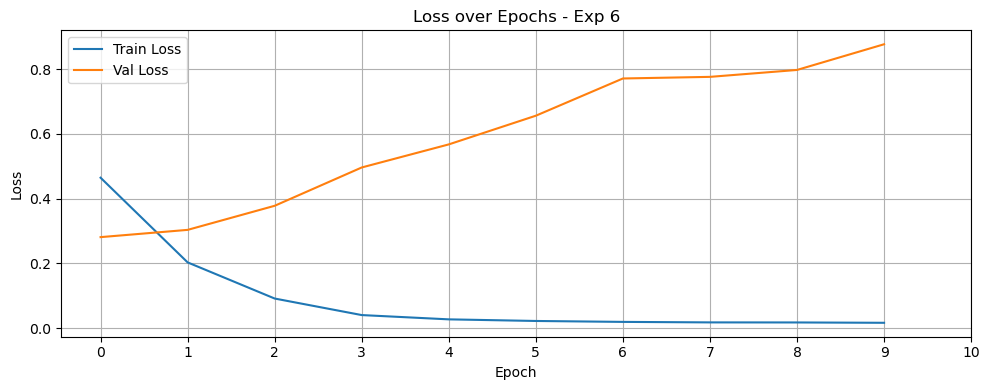


Training time: 169.29 seconds

=========== Experiment-7 ===========
Vocab Size: 10000, Stopwords: Removed, Sequence Length: Natural
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6000
           1       0.95      0.96      0.96      6000
           2       0.85      0.86      0.86      6000
           3       0.86      0.85      0.86      6000

    

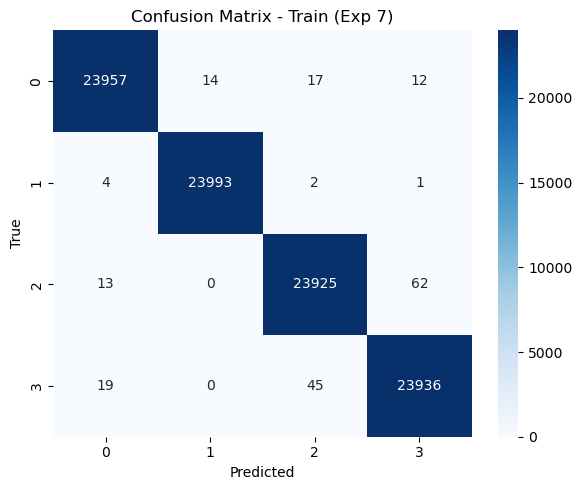

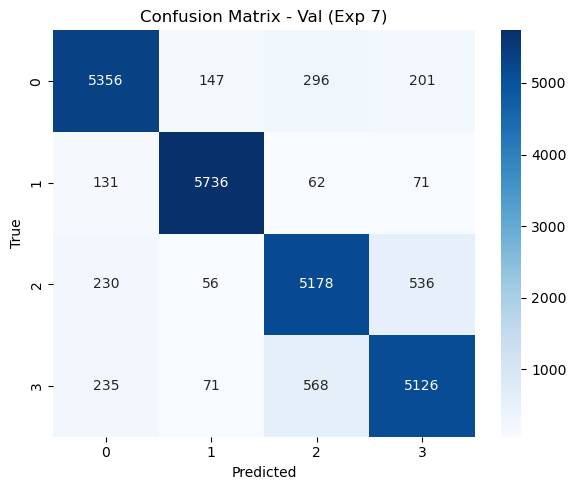

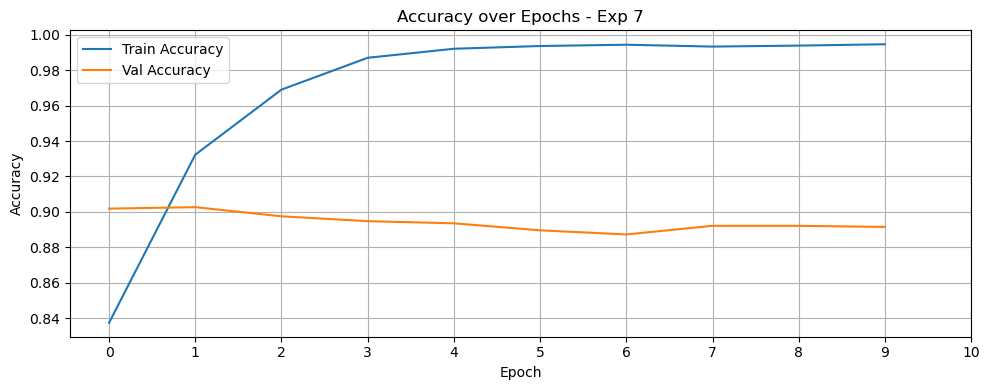

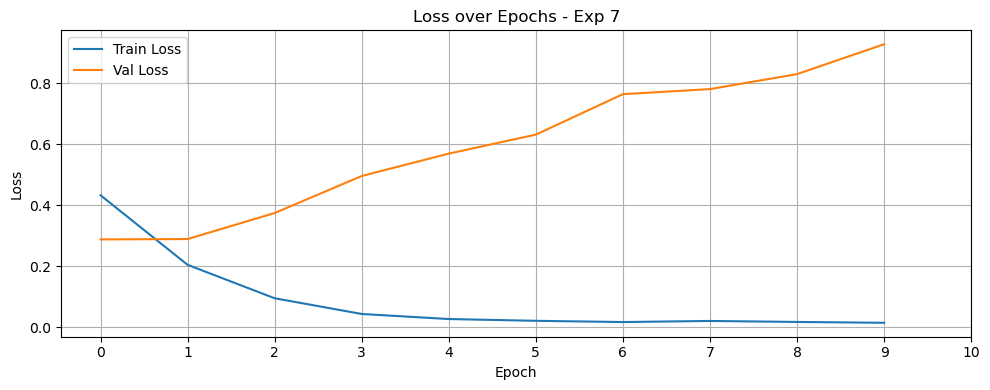


Training time: 199.73 seconds

=========== Experiment-8 ===========
Vocab Size: 10000, Stopwords: Removed, Sequence Length: Fixed(128)
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6000
           1       0.93      0.97      0.95      6000
           2       0.85      0.86      0.85      6000
           3       0.87      0.84      0.85      6000



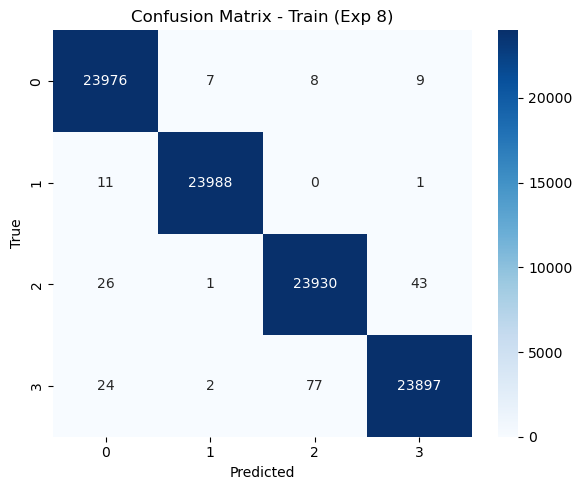

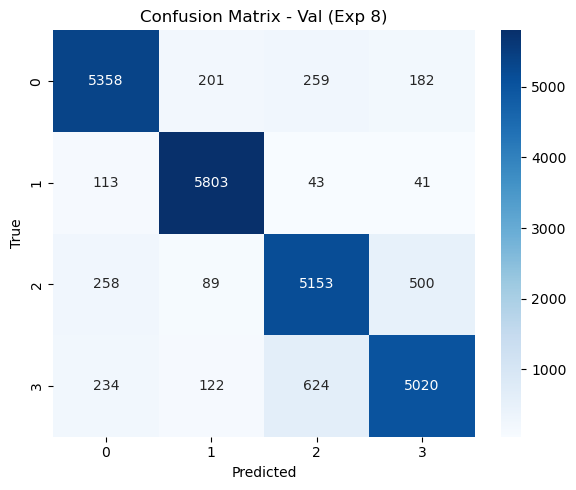

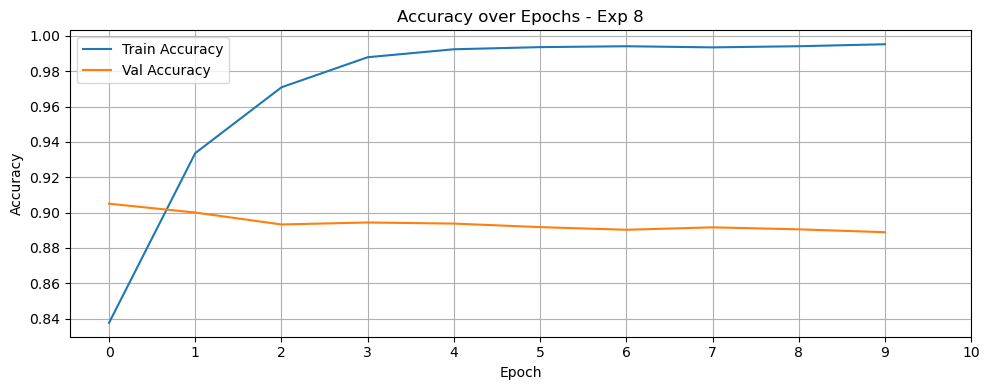

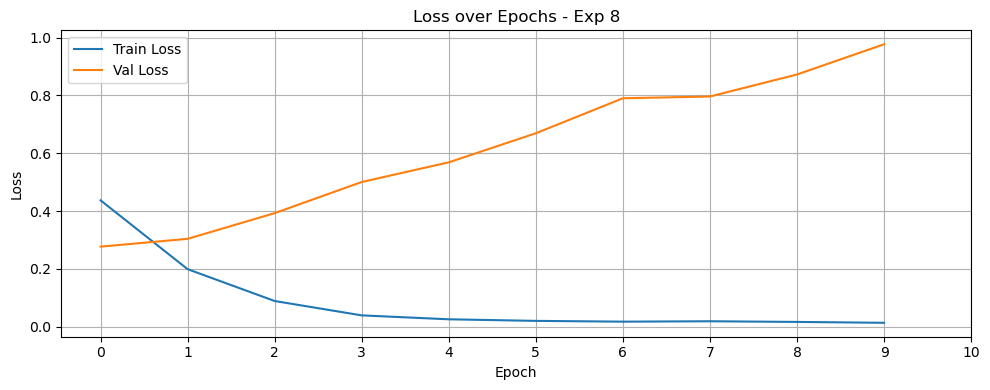


Training time: 190.75 seconds

=========== Experiment-9 ===========
Vocab Size: 20000, Stopwords: Kept, Sequence Length: Natural
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6000
           1       0.95      0.97      0.96      6000
           2       0.85      0.86      0.86      6000
           3       0.87      0.86      0.86      6000

    ac

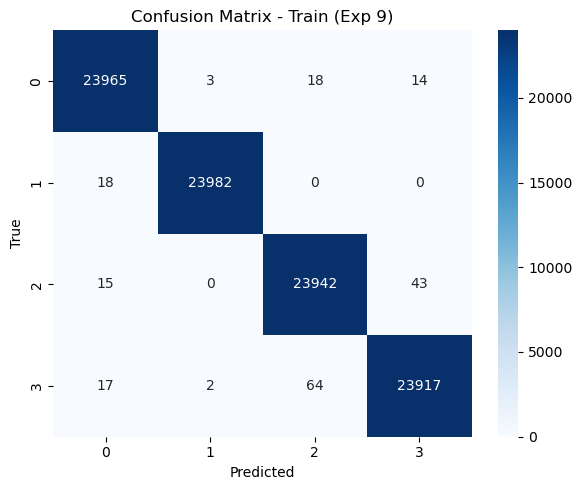

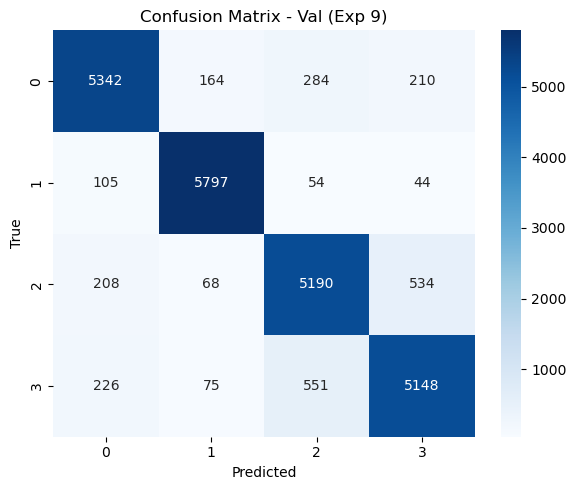

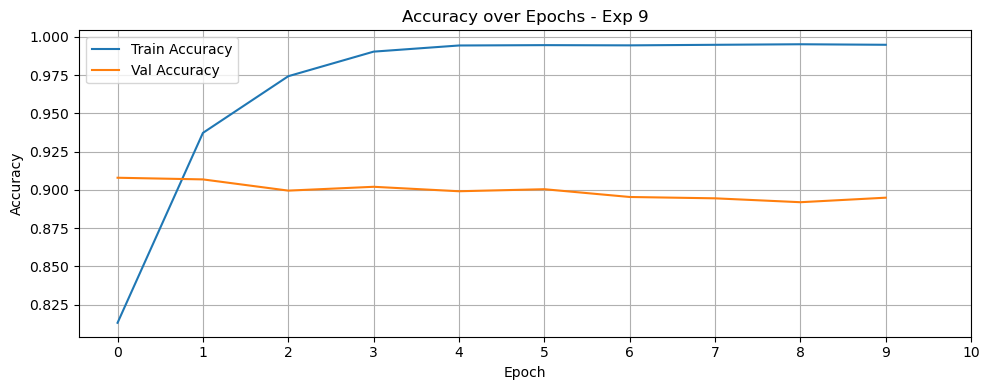

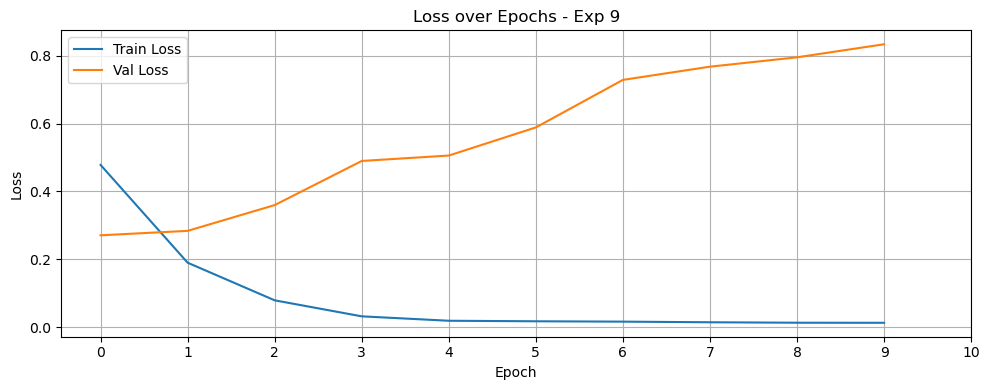


Training time: 321.33 seconds

=========== Experiment-10 ===========
Vocab Size: 20000, Stopwords: Kept, Sequence Length: Fixed(128)
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6000
           1       0.96      0.95      0.96      6000
           2       0.87      0.84      0.86      6000
           3       0.84      0.89      0.87      6000

   

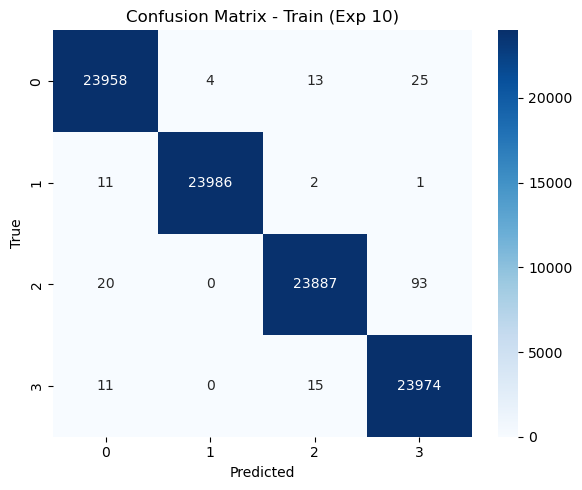

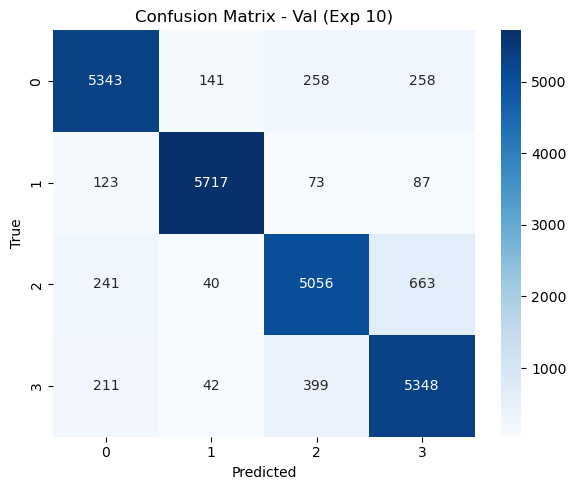

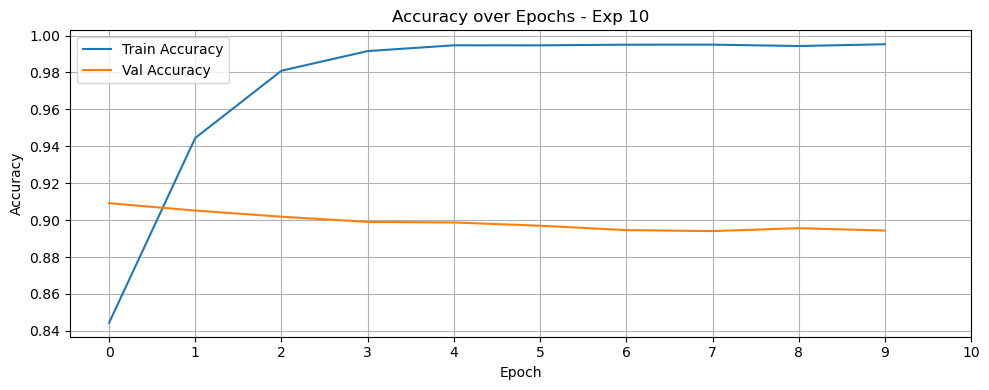

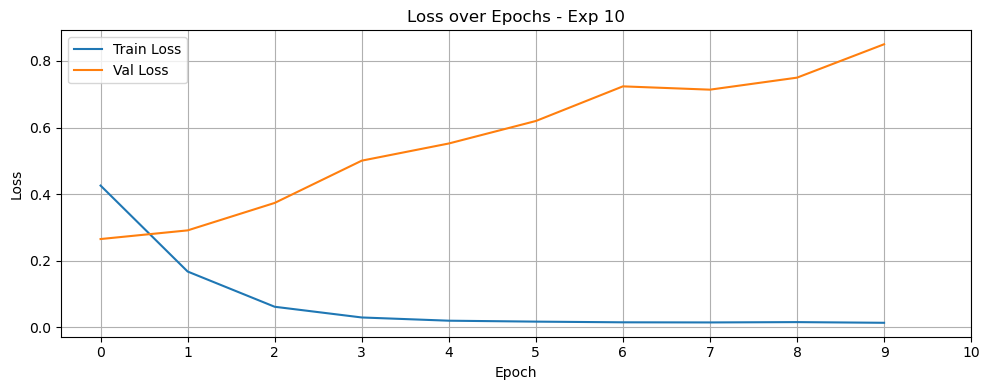


Training time: 234.31 seconds

=========== Experiment-11 ===========
Vocab Size: 20000, Stopwords: Removed, Sequence Length: Natural
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6000
           1       0.95      0.97      0.96      6000
           2       0.88      0.84      0.86      6000
           3       0.85      0.88      0.87      6000

  

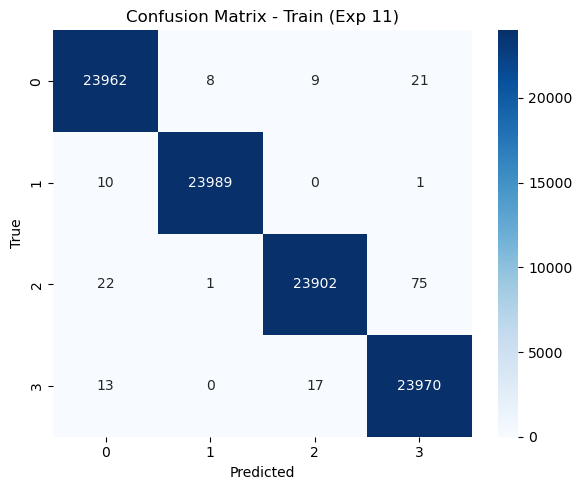

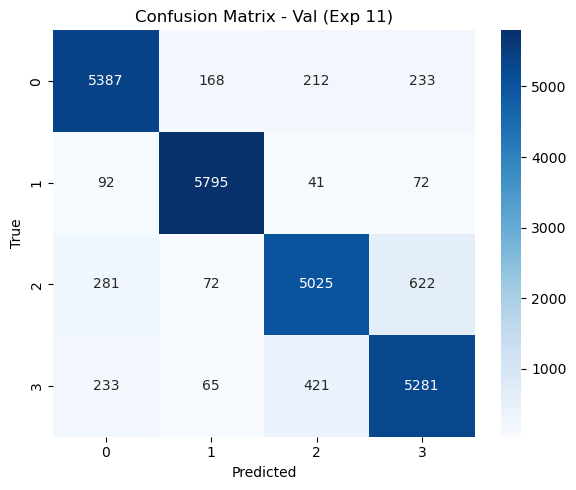

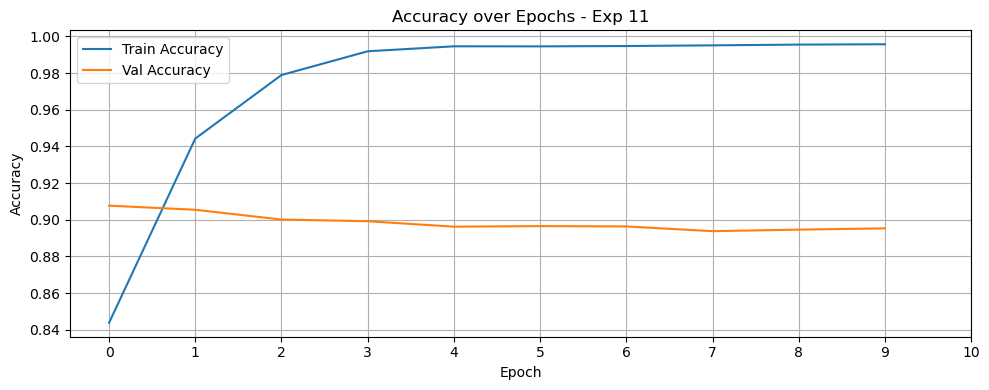

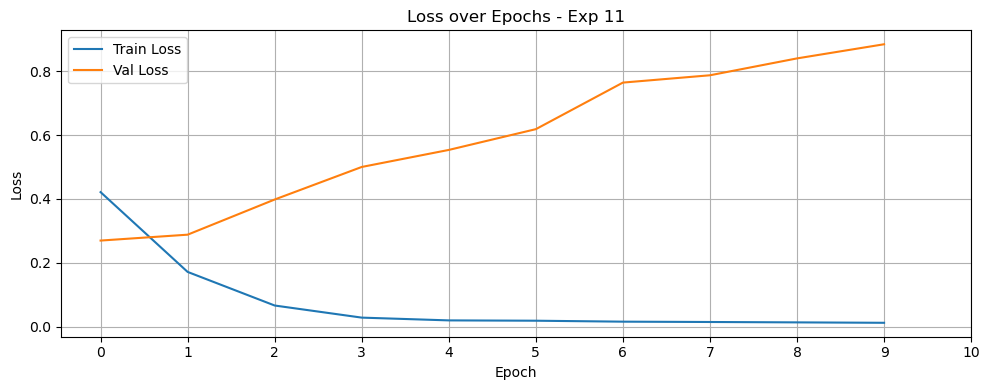


Training time: 309.97 seconds

=========== Experiment-12 ===========
Vocab Size: 20000, Stopwords: Removed, Sequence Length: Fixed(128)
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step

--- Train Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


--- Val Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6000
           1       0.95      0.96      0.96      6000
           2       0.88      0.83      0.86      6000
           3       0.84      0.89      0.86      6000



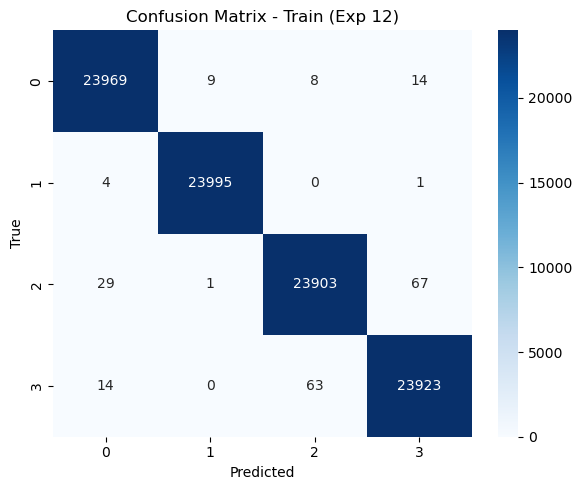

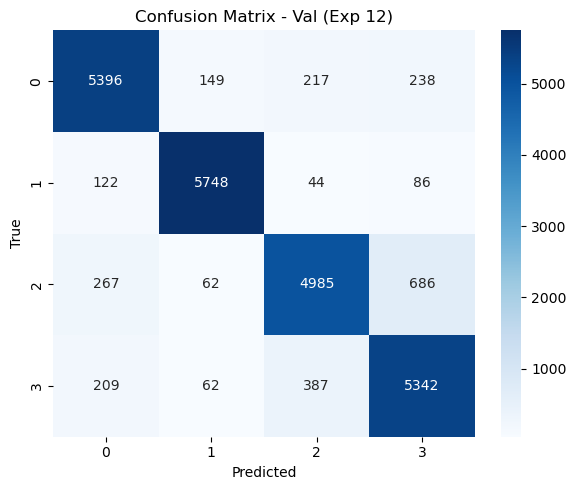

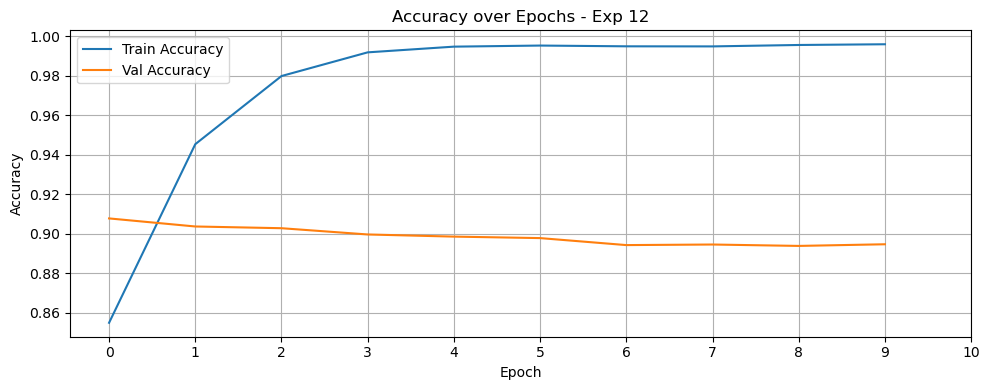

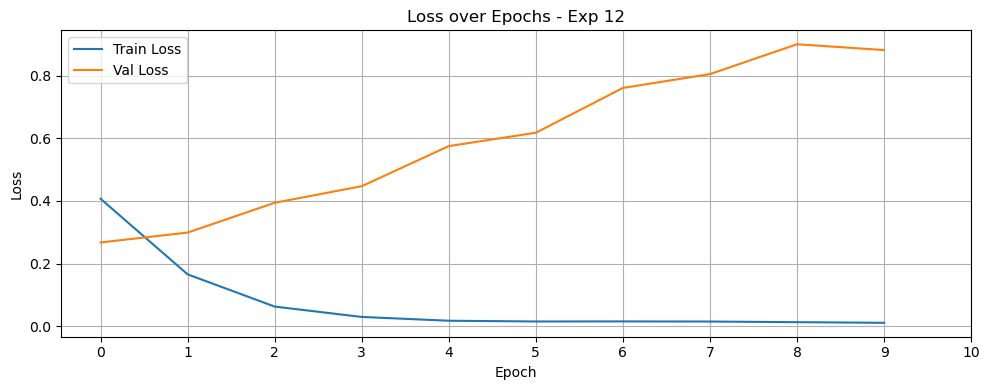


Training time: 228.99 seconds


In [109]:
results = []
exp_num = 1

for vocab_size in [5000, 10000, 20000]:
    for stopwords_removed in [False, True]:
        for seq_len in [None, 128]:
            result = run_experiment(
                exp_num=exp_num,
                vocab_size=vocab_size,
                remove_stopwords=stopwords_removed,
                fixed_seq_len=seq_len,
                embedding_index=embedding_index,
                raw_train_texts=raw_train_texts,
                train_labels=train_labels,
                raw_val_texts=raw_val_texts,
                val_labels=val_labels,
                embedding_dim=200
            )
            results.append(result)
            exp_num += 1


**Base Line Model Results Summary Table:**

In [111]:
results_df = pd.DataFrame(results)
print("\n===== Summary of All Experiments =====")
results_df.sort_values(by='Val Accuracy', ascending=False).to_string(index=False)



===== Summary of All Experiments =====


' Experiment  Vocab Size  Stopwords Removed Sequence Length  Train Accuracy  Val Accuracy  Train Loss  Val Loss  Training Time (s)\n         11       20000               True         Natural        0.995719      0.895333    0.011814  0.885180             309.97\n          9       20000              False         Natural        0.994875      0.894875    0.013742  0.833159             321.33\n         12       20000               True      Fixed(128)        0.995844      0.894625    0.010993  0.881515             228.99\n         10       20000              False      Fixed(128)        0.995292      0.894333    0.013681  0.850208             234.31\n          7       10000               True         Natural        0.994677      0.891500    0.014337  0.928586             199.73\n          5       10000              False         Natural        0.994385      0.890667    0.016715  0.865492             182.17\n          6       10000              False      Fixed(128)        0.994073      0.

In [112]:
results_df.sort_values(by='Val Accuracy', ascending=False).head(15)

Experiment  Vocab Size  Stopwords Removed Sequence Length  Train Accuracy  \
10          11       20000               True         Natural        0.995719   
8            9       20000              False         Natural        0.994875   
11          12       20000               True      Fixed(128)        0.995844   
9           10       20000              False      Fixed(128)        0.995292   
6            7       10000               True         Natural        0.994677   
4            5       10000              False         Natural        0.994385   
5            6       10000              False      Fixed(128)        0.994073   
7            8       10000               True      Fixed(128)        0.995260   
0            1        5000              False         Natural        0.991990   
1            2        5000              False      Fixed(128)        0.992063   
3            4        5000               True      Fixed(128)        0.992906   
2            3        5000               True         Natural        0.992698   

    Val Accuracy  Train Loss  Val Loss  Training Time (s)  
10      0.895333    0.011814  0.885180             309.97  
8       0.894875    0.013742  0.833159             321.33  
11      0.894625    0.010993  0.881515             228.99  
9       0.894333    0.013681  0.850208             234.31  
6       0.891500    0.014337  0.928586             199.73  
4       0.890667    0.016715  0.865492             182.17  
5       0.889000    0.016116  0.877041             169.29  
7       0.888917    0.013677  0.977204             190.75  
0       0.879500    0.023002  0.914442             211.93  
1       0.879500    0.022832  0.946696             166.50  
3       0.876750    0.020500  0.942232             167.23  
2       0.874958    0.020969  0.996274             189.31

Based on the final results summary table, the third-level vocabulary size (20,000), text without stopwords, and natural sequence length in Experiment-11 resulted in higher validation accuracy, though with moderately high training time. However, Experiment-12, which used the same vocabulary size and stopword removal but a fixed sequence length of 128, achieved nearly the same validation accuracy as the top-ranked Experiment-1, with reduced training time. Furthermore, the log loss of Experiment-12 was slightly better than that of Experiment-11.

Therefore, the following parameter values will be fixed for the remaining experiments with RNN, LSTM, and 1D-CNN models, using Experiment-12 with the DNN as the baseline for comparison.
+ Vocab size = 20,000
+ Stopwords removed
+ Sequence Length - Fixed at 128


**Visual Analysis of the Test Outcome:**

Validation Accuracy Vs Vocabulary Size:

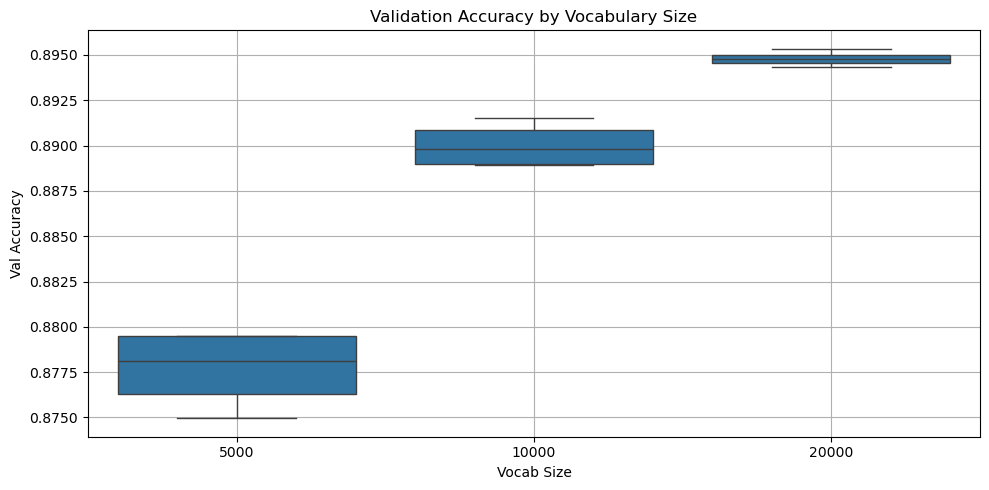

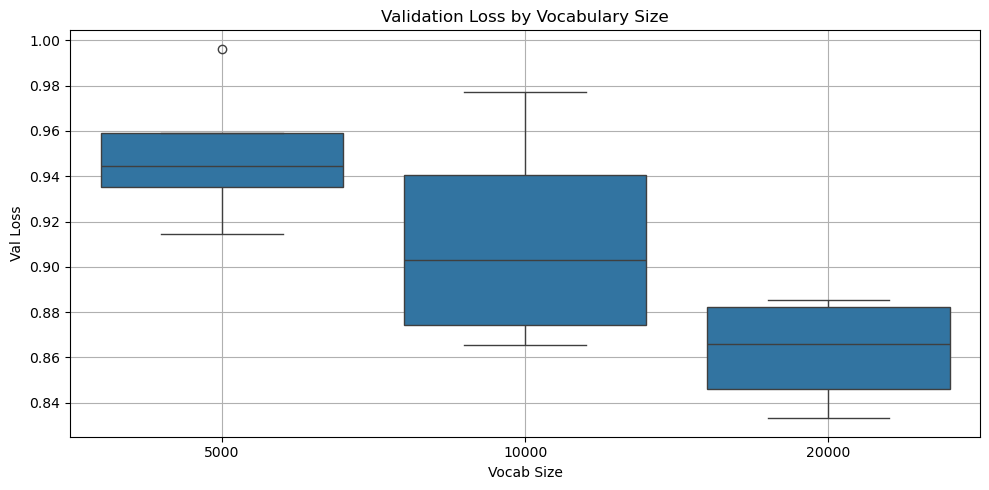

In [113]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Vocab Size', y='Val Accuracy', data=results_df)
plt.title('Validation Accuracy by Vocabulary Size')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='Vocab Size', y='Val Loss', data=results_df)
plt.title('Validation Loss by Vocabulary Size')
plt.grid(True)
plt.tight_layout()
plt.show()


Validation Accuracy Vs Stopword Removal:

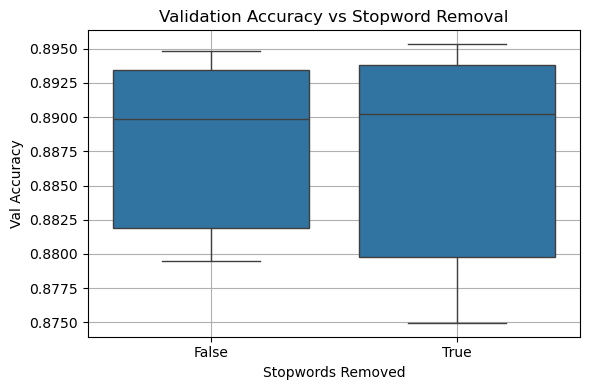

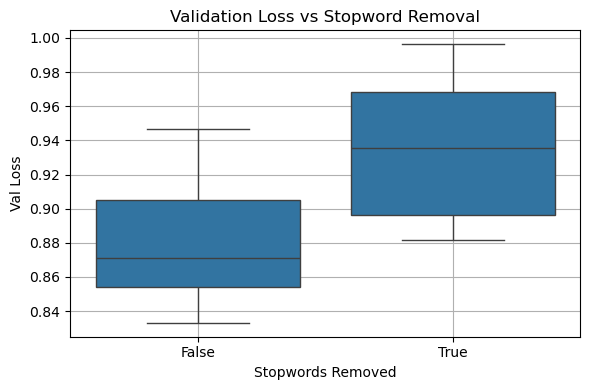

In [114]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Stopwords Removed', y='Val Accuracy', data=results_df)
plt.title('Validation Accuracy vs Stopword Removal')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='Stopwords Removed', y='Val Loss', data=results_df)
plt.title('Validation Loss vs Stopword Removal')
plt.grid(True)
plt.tight_layout()
plt.show()


Validation Accuracy Vs Sequence Length:

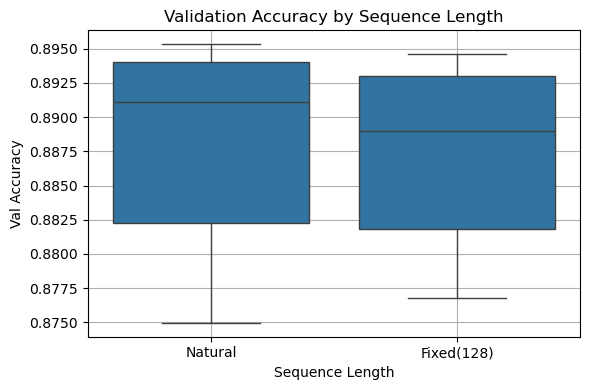

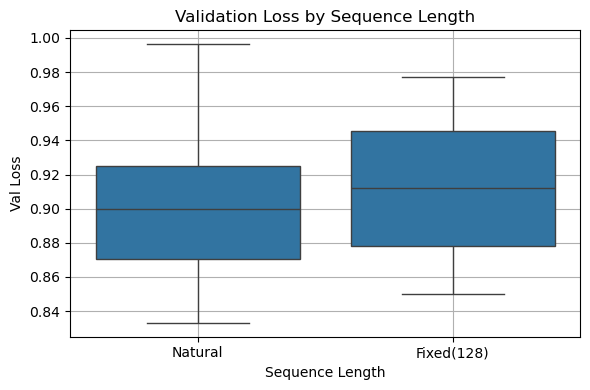

In [115]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Sequence Length', y='Val Accuracy', data=results_df)
plt.title('Validation Accuracy by Sequence Length')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='Sequence Length', y='Val Loss', data=results_df)
plt.title('Validation Loss by Sequence Length')
plt.grid(True)
plt.tight_layout()
plt.show()


Training Time by Experiment:

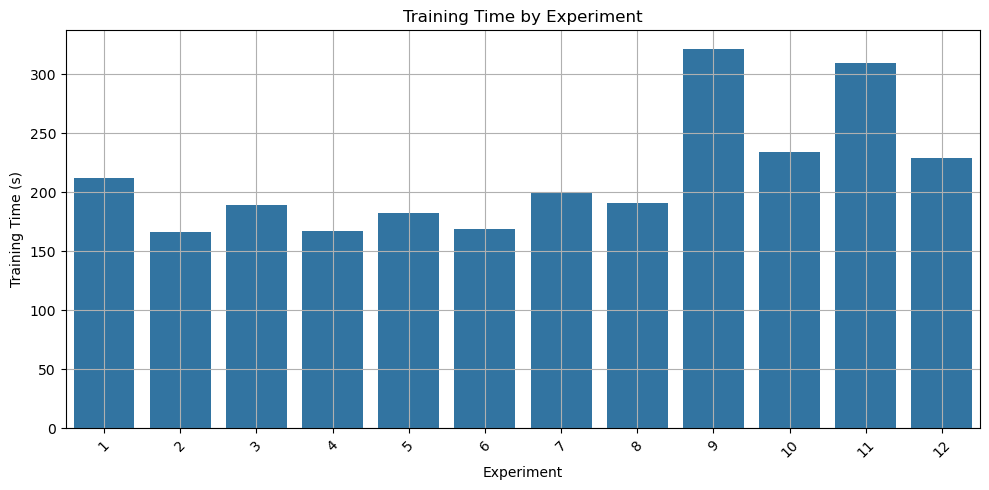

In [116]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Experiment', y='Training Time (s)', data=results_df)
plt.title('Training Time by Experiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


---
### **Modelling:**

All remaining experiment setup will be conducted using the following experimental setup:

+ Vocab Size        - 20,000
+ Stopwords	Removed - True
+ Sequence Length	- Fixed at 128
+ Embeddings	    - Pretrained GloVe 200D (non-trainable)
+ Epochs	        - 20
+ Batch Size	    - 100
+ Loss Function	    - Sparse Categorical Crossentropy
+ Optimizer	        - Adam

Therefore, let's prepare the dataset for modelling:

In [117]:
#nltk.download('stopwords')
# Parameters
vocab_size = 20000
sequence_len = 128
stop_words = set(stopwords.words('english'))

# Prepare cleaned text (stopword removal)
def clean_text(texts):
    return [' '.join([word for word in text.lower().split() if word not in stop_words])
            for text in texts]

train_texts = clean_text(df_train_model['text'].tolist())
val_texts = clean_text(df_val_model['text'].tolist())
test_texts = clean_text(df_test['text'].tolist())

y_train = df_train_model['label'].values
y_val = df_val_model['label'].values
y_test = df_test['label'].values

# Tokenize
tokenizer_rnn = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer_rnn.fit_on_texts(train_texts)
train_seq = tokenizer_rnn.texts_to_sequences(train_texts)
val_seq = tokenizer_rnn.texts_to_sequences(val_texts)
test_seq = tokenizer_rnn.texts_to_sequences(test_texts)

# Pad sequences to fixed length
X_train_rnn = pad_sequences(train_seq, maxlen=sequence_len, padding='post', truncating='post')
X_val_rnn = pad_sequences(val_seq, maxlen=sequence_len, padding='post', truncating='post')
X_test_rnn = pad_sequences(test_seq, maxlen=sequence_len, padding='post', truncating='post')


In [118]:
print(f"X_test_rnn shape: {X_test_rnn.shape}")
print(f"y_test shape: {y_test.shape}")

X_test_rnn shape: (7600, 128)
y_test shape: (7600,)


**Rebuilding the Embedding Matrix**

In [119]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer_rnn.word_index

for word, i in word_index.items():
    if i < vocab_size:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec


### **EXPERIMENT-B**

A function to perform simple RNN in Unidireactional and bi directional with the experimented parameters previously, lets try both models and pick the best model for hyper parameter tuning.

In [ ]:
def run_rnn_experiment(X_train, y_train, X_val, y_val,
                       vocab_size, embedding_dim, embedding_matrix,
                       rnn_type='simple', rnn_units=128, dropout_rate=0.5,
                       bidirectional=False, epochs=10, batch_size=100,
                       experiment_name="RNN",
                       X_test=None, y_test=None):

    start_time = time.time()
    input_length = X_train.shape[1]

    # Select RNN Layer
    if rnn_type == 'simple':
        rnn_layer = SimpleRNN(rnn_units, return_sequences=False)
    elif rnn_type == 'lstm':
        rnn_layer = LSTM(rnn_units, return_sequences=False)
    elif rnn_type == 'gru':
        rnn_layer = GRU(rnn_units, return_sequences=False)
    else:
        raise ValueError("Unsupported rnn_type. Choose from: 'simple', 'lstm', 'gru'.")

    if bidirectional:
        rnn_layer = Bidirectional(rnn_layer)

    # Build Model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                  weights=[embedding_matrix], input_length=input_length, trainable=False),
        rnn_layer,
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nRunning {experiment_name}")
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=0)

    training_time = time.time() - start_time

    # Predictions
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    y_test_pred = np.argmax(model.predict(X_test), axis=1) if X_test is not None else None

    # Classification Reports
    print("\n" + "=" * 50)
    print(f"{experiment_name} - Classification Reports")
    print("=" * 50)

    print("\n[Train Set]")
    print(classification_report(y_train, y_train_pred))

    print("\n[Validation Set]")
    print(classification_report(y_val, y_val_pred))

    if X_test is not None and y_test is not None:
        print("\n[Test Set]")
        print(classification_report(y_test, y_test_pred))

    # Confusion Matrices 
    print("\n" + "=" * 50)
    print(f"{experiment_name} - Confusion Matrices")
    print("=" * 50)

    num_matrices = 3 if X_test is not None else 2
    fig, axes = plt.subplots(1, num_matrices, figsize=(6 * num_matrices, 5))

    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=axes[0])
    axes[0].set_title(f'Train Confusion Matrix - {experiment_name}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Validation Confusion Matrix - {experiment_name}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    if X_test is not None:
        cm_test = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
        axes[2].set_title(f'Test Confusion Matrix - {experiment_name}')
        axes[2].set_xlabel('Predicted')
        axes[2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Accuracy Plot
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xticks(ticks=range(epochs + 1))  
    plt.title(f'{experiment_name} Accuracy Over Epochs')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xticks(ticks=range(epochs + 1))  
    plt.title(f'{experiment_name} Loss Over Epochs')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, history, {
        'Experiment': experiment_name,
        'Train Accuracy': history.history['accuracy'][-1],
        'Val Accuracy': history.history['val_accuracy'][-1],
        'Train Loss': history.history['loss'][-1],
        'Val Loss': history.history['val_loss'][-1],
        'Test Accuracy': (np.mean(y_test_pred == y_test) if y_test_pred is not None else None),
        'Training Time (s)': round(training_time, 2)
    }



#### **Experiment-B1 : Simple RNN - Uni**

**B1: Simple RNN (Unidirectional):**
This model is a sequential neural network designed for text classification using a Simple RNN layer. It includes:

**Embedding Layer:**
+ Input dimension: 20,000 (vocabulary size)
+ Output dimension: 200 (GloVe 200D embeddings)
+ Weights initialized with pretrained GloVe embeddings
+ Set as non-trainable to preserve pretrained knowledge

**Simple RNN Layer:**
+ Type: Unidirectional SimpleRNN
+ Units: 64
+ Returns the final hidden state for classification

**Dropout Layer:**
+ Rate: 0.5

**Dense Hidden Layer:**
+ Units: 128
+ Activation: ReLU

**Second Dropout Layer:**
+ Rate: 0.4

**Output Layer:**
+ Units: 4 ( 4 target classes)
+ Activation: Softmax for multi-class classification

**Compilation:**
+ Loss: Sparse Categorical Crossentropy
+ Optimizer: Adam


Running B1 Simple RNN (Uni)
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

B1 Simple RNN (Uni) - Classification Reports

[Train Set]
              precision    recall  f1-score   support

           0       0.25      1.00      0.40     24000
           1       0.00      0.00      0.00     24000
           2       0.00      0.00      0.00     24000
           3       0.94      0.00      0.00     24000

    accuracy                           0.25     96000
   macro avg       0.30      0.25      0.10     96000
weighted avg       0.30      0.25      0.10     96000


[Validation Set]
              precision    recall  f1-score   support

           0       0.25      1.00      0.40      6000
           1       0.00      0.00      0.00      6000
           2       0.00      0.00      0.00      6000
           3       0.80      0.00      0.00      6000

    accuracy                           0.25     24000
   macr

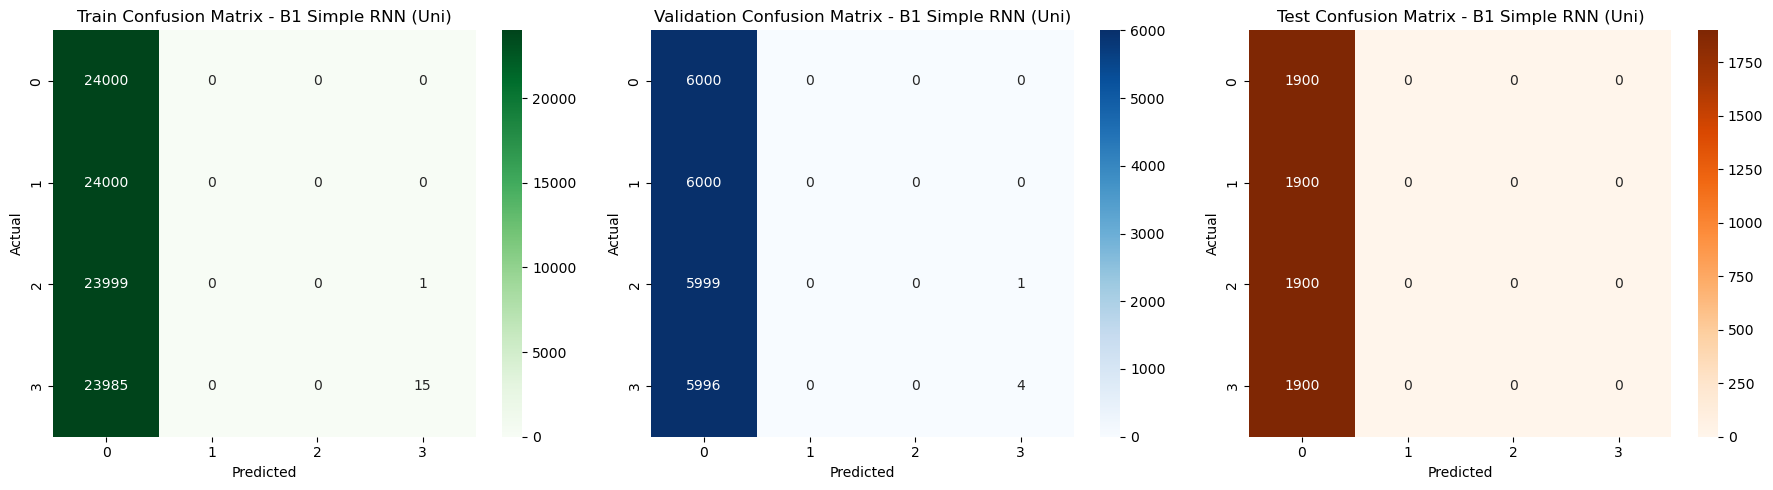

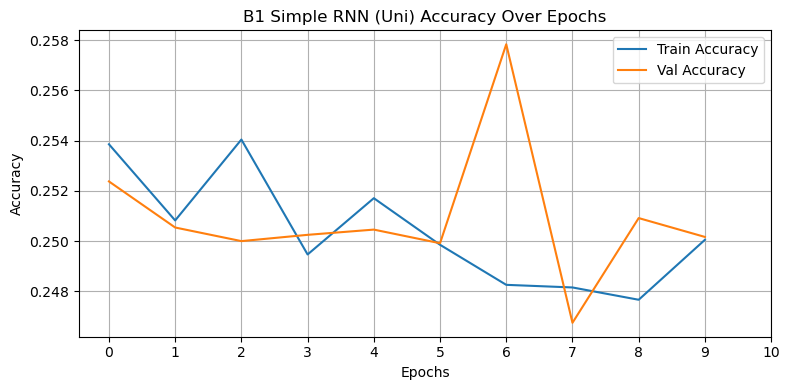

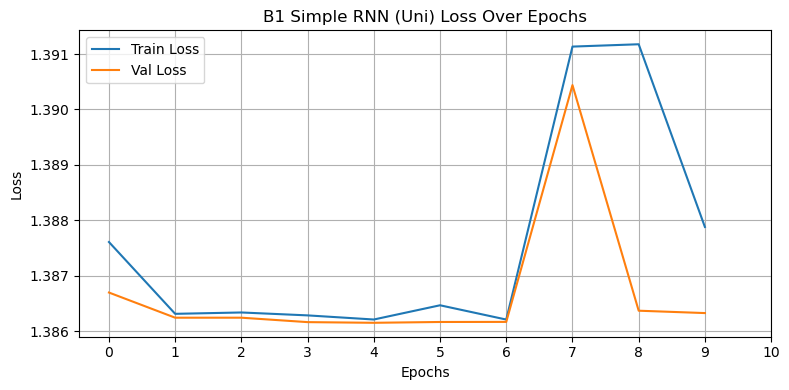

{'Experiment': 'B1 Simple RNN (Uni)',
 'Train Accuracy': 0.2500520944595337,
 'Val Accuracy': 0.250166654586792,
 'Train Loss': 1.3878793716430664,
 'Val Loss': 1.3863248825073242,
 'Test Accuracy': 0.25,
 'Training Time (s)': 245.12}

In [ ]:
model_b1, history_b1, result_b1 = run_rnn_experiment(
    X_train=X_train_rnn,
    y_train=y_train,
    X_val=X_val_rnn,
    y_val=y_val,
    X_test=X_test_rnn,
    y_test=y_test,
    vocab_size=20000,
    embedding_dim=200,
    embedding_matrix=embedding_matrix,
    rnn_type='simple',
    rnn_units=64,
    dropout_rate=0.4,
    bidirectional=False,
    epochs=10,
    batch_size=100,
    experiment_name="B1 Simple RNN (Uni)"
)

result_b1


The overall performance of the Simple RNN unidirectional model on the AG News classification task is consistently inadequate across all evaluation metrics and visual diagnostics. The classification report reveals that the model defaults almost entirely to predicting a single class, class 0 (World), regardless of the input. While it achieves perfect recall for class 0, it fails to identify any instances from the remaining three classes: Sports, Business, and Sci/Tech. This results in precision, recall, and F1 scores of zero for these classes. Consequently, the macro and weighted average F1 scores remain around 0.10, indicating extremely poor performance, comparable to that of a random classifier.

The model’s confusion matrices further reinforce this conclusion. Across training, validation, and test sets, almost all predictions fall into the top-left cell of the matrix, representing predictions for class 0. Predictions for the other classes are nearly absent, demonstrating that the model lacks the ability to differentiate between news categories. This strong imbalance in prediction outcomes reflects a degenerate solution, where the model simply memorizes the dominant class without learning any meaningful distinctions among the labels.

The accuracy over epochs also shows a stagnant and erratic pattern. Both training and validation accuracy plateau around 0.25, which corresponds to the chance level for a four-class problem. There is no evidence of a learning trajectory or convergence, and the accuracy curves exhibit only minor fluctuations without any consistent upward trend. Notably, the training and validation curves stay very close together, which might suggest an absence of overfitting but this is only because the model fails to fit the data at all, highlighting severe underfitting.

The loss over epochs tells a similar story. Both training and validation loss remain high, around 1.38 to 1.39, with no meaningful downward trend. This is expected when a model cannot effectively minimize its loss function. The flat and erratic nature of the loss curves indicates that the model fails to make useful adjustments to its weights during training. The lack of divergence between training and validation loss is not a sign of good generalization but rather a reflection of the model’s failure to learn.

In terms of efficiency, the training process took approximately 245.12 seconds. Despite this modest training time, the model does not deliver any practical results. This underscores the inefficiency of allocating computational resources to a model architecture that lacks the capacity to handle the complexity of natural language classification.

##### **Experiment-B2 : Simple RNN - Bi**

**B1: Simple RNN (Bi-Directional):**
This model is a sequential neural network designed for text classification using a Simple RNN layer. It includes:

**Embedding Layer:**
+ Input dimension: 20,000 (vocabulary size)
+ Output dimension: 200 (GloVe 200D embeddings)
+ Weights initialized with pretrained GloVe embeddings
+ Set as non-trainable to preserve pretrained knowledge

**Simple RNN Layer:**
+ Type: Bi-Directional SimpleRNN
+ Units: 64
+ Returns the final hidden state for classification

**Dropout Layer:**
+ Rate: 0.5

**Dense Hidden Layer:**
+ Units: 128
+ Activation: ReLU

**Second Dropout Layer:**
+ Rate: 0.4

**Output Layer:**
+ Units: 4 ( 4 target classes)
+ Activation: Softmax for multi-class classification

**Compilation:**
+ Loss: Sparse Categorical Crossentropy
+ Optimizer: Adam


Running B2 Simple RNN (Bi)
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

B2 Simple RNN (Bi) - Classification Reports

[Train Set]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89     24000
           1       0.91      0.99      0.95     24000
           2       0.90      0.82      0.85     24000
           3       0.83      0.90      0.86     24000

    accuracy                           0.89     96000
   macro avg       0.89      0.89      0.89     96000
weighted avg       0.89      0.89      0.89     96000


[Validation Set]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      6000
           1       0.90      0.99      0.94      6000
           2       0.89      0.80      0.85      6000
           3       0.82      0.91      0.86      6000

    accuracy                           0.89     24000
   macro

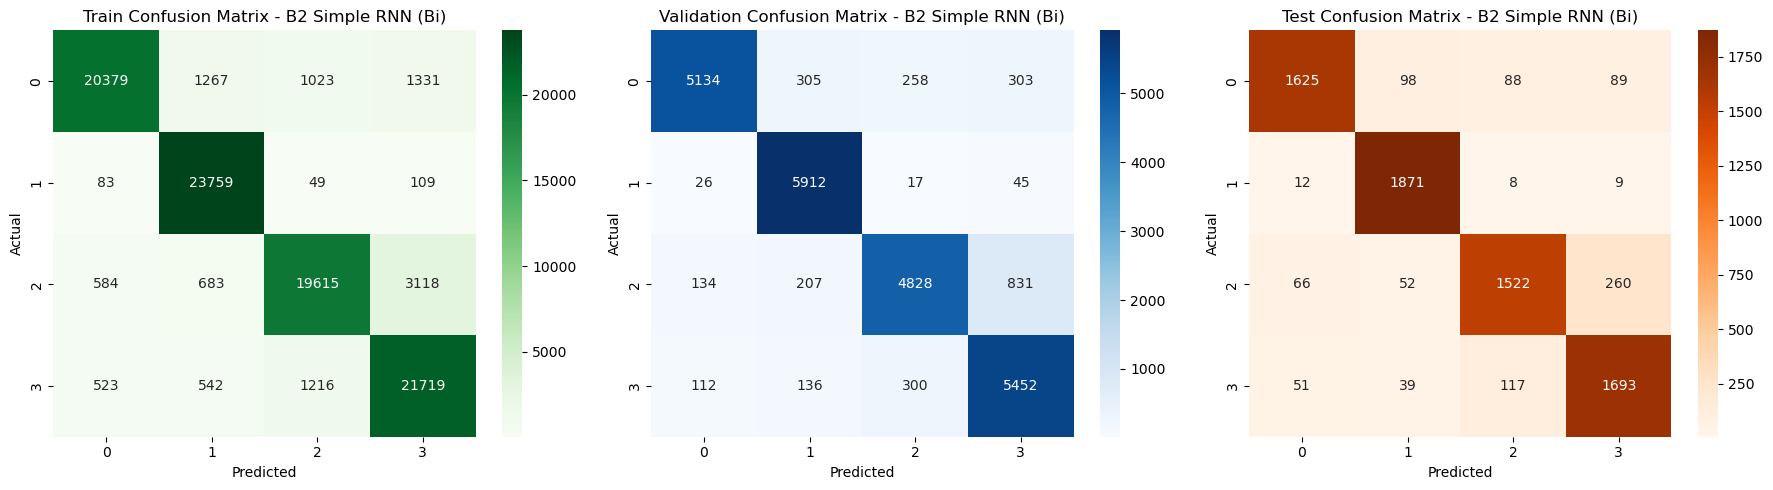

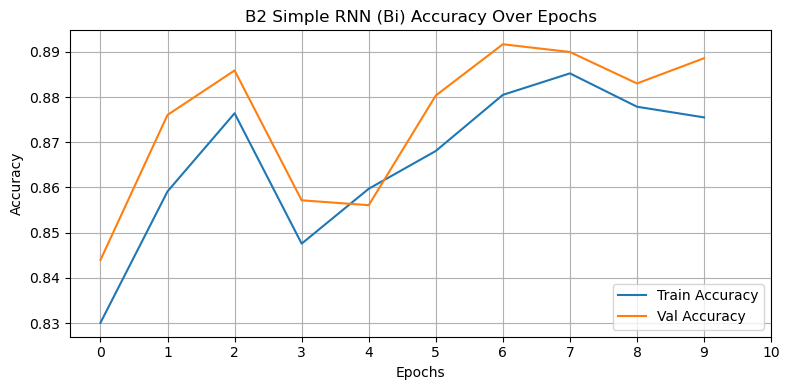

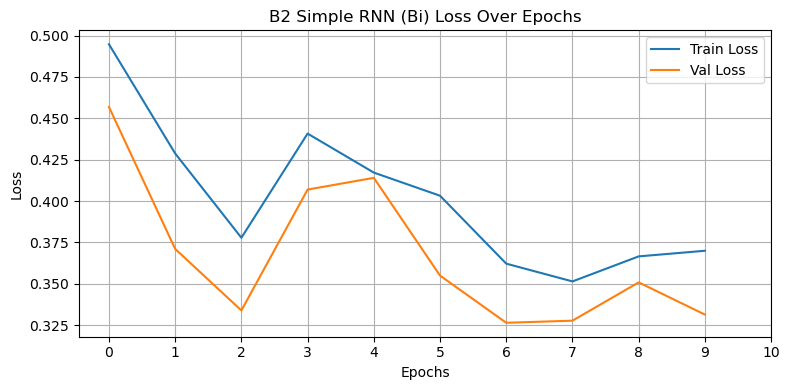

{'Experiment': 'B2 Simple RNN (Bi)',
 'Train Accuracy': 0.8755000233650208,
 'Val Accuracy': 0.8885833621025085,
 'Train Loss': 0.36996519565582275,
 'Val Loss': 0.3314141035079956,
 'Test Accuracy': 0.8830263157894737,
 'Training Time (s)': 312.82}

In [129]:
model_b2, history_b2, result_b2 = run_rnn_experiment(
    X_train=X_train_rnn,
    y_train=y_train,
    X_val=X_val_rnn,
    y_val=y_val,
    X_test=X_test_rnn,
    y_test=y_test,
    vocab_size=20000,
    embedding_dim=200,
    embedding_matrix=embedding_matrix,
    rnn_type='simple',
    rnn_units=64,
    dropout_rate=0.4,
    bidirectional=True,
    epochs=10,
    batch_size=100,
    experiment_name="B2 Simple RNN (Bi)"
)

result_b2

The analysis of the bidirectional RNN model on the AG News dataset highlights its superior performance compared to the unidirectional RNN across multiple evaluation metrics. The classification report shows that the bidirectional model achieves significantly higher accuracy, reaching approximately 0.89 on the training and validation sets and 0.88 on the test set, demonstrating its strong ability to correctly categorize news articles. It performs well across all four news categories (World, Sports, Business, and Sci/Tech) with balanced precision, recall, and F1 scores.

A closer look at the class-specific metrics reveals particularly strong results for categories such as Sports and World, with high precision and recall. For example, class 1 (Sports) achieves a recall between 0.98 and 0.99 and an F1 score around 0.94, while class 0 (World) also records robust performance. Although class 2 (Business) and class 3 (Sci/Tech) show slightly lower scores, they remain within a high-performing range, reinforcing the model's well-rounded effectiveness.

This performance is visually confirmed by the confusion matrices, which show a strong diagonal pattern across the training, validation, and test sets. This indicates that most samples are correctly classified. Misclassifications are relatively minor and evenly distributed, which reflects the model’s balanced handling of all classes. The consistency of these patterns across different data splits suggests strong generalization and minimal overfitting.

The accuracy and loss curves over training epochs further support these findings. Accuracy steadily increases and stabilizes above 0.88, while loss decreases and stays below 0.4 throughout training. The close alignment of the training and validation curves for both accuracy and loss indicates effective learning and strong generalization without notable overfitting. The model converges efficiently, with most improvements tapering off in later epochs, and the training process takes approximately 313 seconds.

In summary, the bidirectional RNN’s ability to process sequences in both forward and backward directions enables it to capture richer contextual information. This advantage allows it to outperform the unidirectional model across all major performance indicators. Its consistently high accuracy, balanced classification across categories, and efficient training dynamics make it a reliable model for text classification tasks such as news categorization.

---
### **EXPERIMENT - C: LSTM**

**Experiment- C1 : LSTM (Uni)**

**Embedding Layer:**
+ Input dimension: 20,000 (vocabulary size)
+ Output dimension: 200 (embedding size from GloVe 200D)
+ Weights: Initialized with pretrained GloVe embeddings
+ Trainable: False - embeddings are kept static to preserve pretrained semantic structure
+ Input length: Set based on the padded sequence length from training data

**LSTM Layer:**
+ Type: Unidirectional LSTM
+ Units: 64 (hidden units)
+ Return Sequences: False - only the final hidden state is passed forward
+ Function: Captures temporal dependencies and sequential context in the input text

**Dropout Layer (1st):**
+ Dropout Rate: 0.4

**Dense Hidden Layer:**
+ Units: 128
+ Activation: ReLU

**Dropout Layer (2nd):**
+ Dropout Rate: 0.4

**Output Layer:**
+ Units: 4 (for 4 target class)
+ Activation: Softmax

**Compilation:**
+ Loss Function: Sparse Categorical Crossentropy
+ Optimizer: Adam
+ Metrics: Accuracy


Running C1 LSTM (Uni)
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step

C1 LSTM (Uni) - Classification Reports

[Train Set]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     24000
           1       0.96      0.98      0.97     24000
           2       0.92      0.82      0.87     24000
           3       0.82      0.95      0.88     24000

    accuracy                           0.90     96000
   macro avg       0.91      0.90      0.90     96000
weighted avg       0.91      0.90      0.90     96000


[Validation Set]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      6000
           1       0.95      0.97      0.96      6000
           2       0.91      0.80      0.86      6000
           3       0.81      0.94      0.87      6000

    accuracy                           0.90     24000
   macro avg    

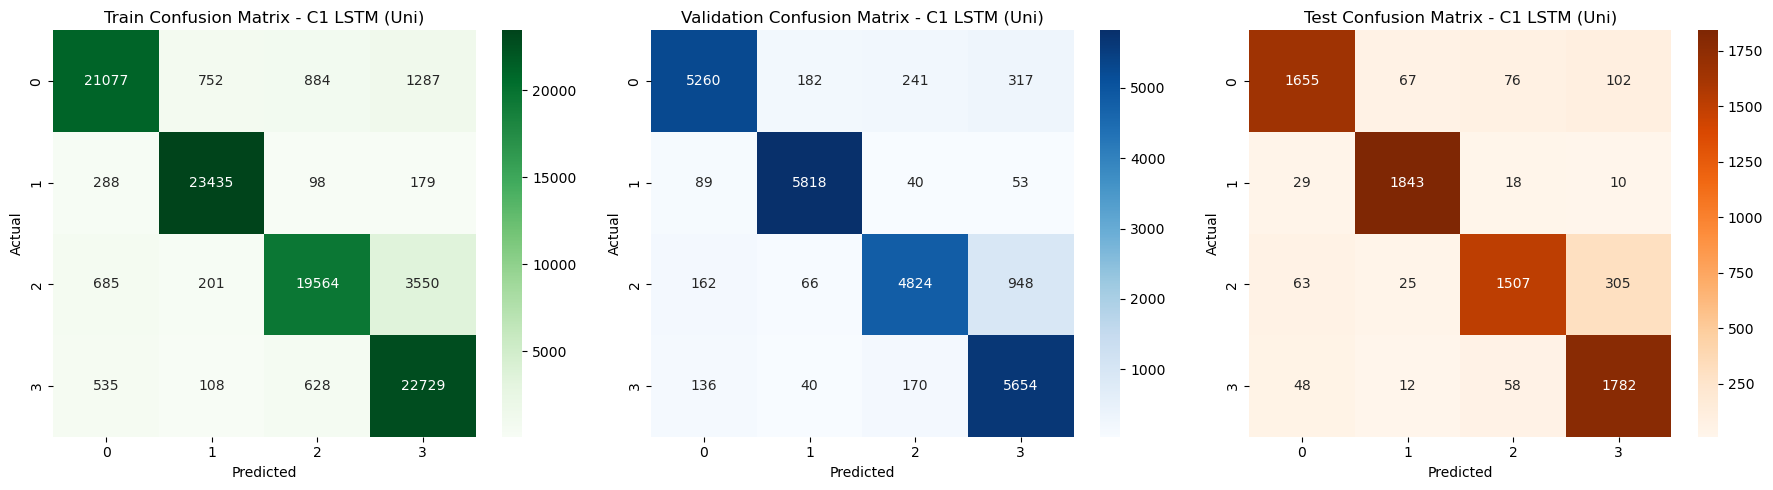

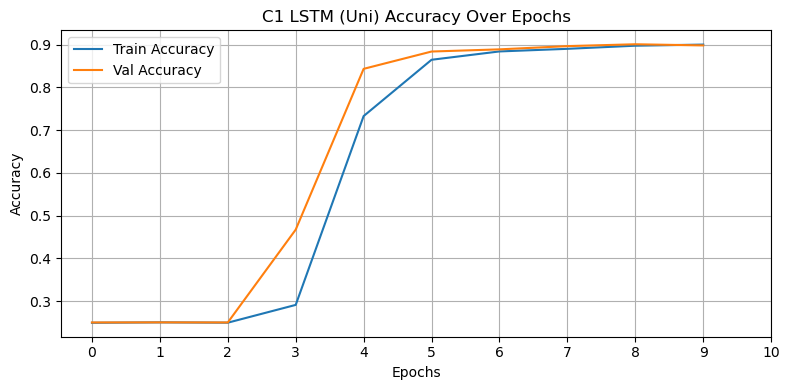

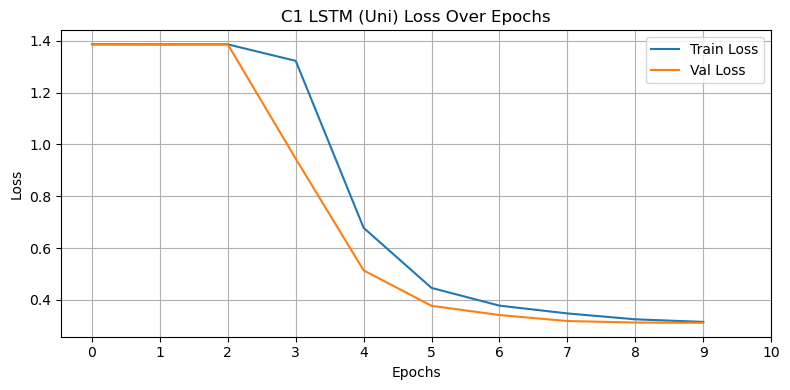

{'Experiment': 'C1 LSTM (Uni)',
 'Train Accuracy': 0.9001353979110718,
 'Val Accuracy': 0.8981666564941406,
 'Train Loss': 0.3146996796131134,
 'Val Loss': 0.31123149394989014,
 'Test Accuracy': 0.8930263157894737,
 'Training Time (s)': 625.09}

In [128]:
model_c1, history_c1, result_c1 = run_rnn_experiment(
    X_train=X_train_rnn,
    y_train=y_train,
    X_val=X_val_rnn,
    y_val=y_val,
    X_test=X_test_rnn,
    y_test=y_test,
    vocab_size=20000,
    embedding_dim=200,
    embedding_matrix=embedding_matrix,
    rnn_type='lstm',
    rnn_units=64,
    dropout_rate=0.4,
    bidirectional=False,
    epochs=10,
    batch_size=100,
    experiment_name="C1 LSTM (Uni)"
)

result_c1

The performance analysis of the uni-directional LSTM model on the AG News dataset reveals a marked improvement over both the uni-directional and bi-directional simple RNN models. Leveraging its capability to capture long-range dependencies in textual data, the LSTM model achieves higher accuracy and a more nuanced understanding of class distinctions, resulting in better classification performance overall.

From the classification report, the model achieves an accuracy of 0.90 on both training and validation sets, and 0.89 on the test set. This consistency across datasets indicates robust generalization and minimal overfitting. The LSTM shows strong, balanced performance across all four classes: World, Sports, Business, and Sci/Tech. Class 1 (Sports) emerges as the best-performing class, with precision and recall nearing 0.95–0.98 and an F1-score close to 0.97. Class 0 (World) and class 3 (Sci/Tech) also show strong metrics, while class 2 (Business) lags slightly in recall, though it still maintains a solid F1-score around 0.85–0.87. This distribution suggests that the LSTM is effective at distinguishing among news categories, with only modest confusion in specific areas.

The confusion matrices reinforce these findings, displaying a dominant diagonal presence that signifies a high rate of correct classifications. While some misclassifications occur, most notably between class 0 (World) and class 2 (Business), and between class 2 and class 3 (Sci/Tech), these errors are relatively balanced and not skewed toward any single class. This indicates that the LSTM does not disproportionately struggle with any particular category, supporting the conclusion that it offers a well-rounded classification capability.

Training dynamics, as shown in the accuracy and loss plots, further illustrate the LSTM’s effectiveness. Both training and validation accuracy steadily increase, converging near 0.90, while loss consistently decreases, reaching low values by the final epochs. The gap between training and validation curves remains narrow throughout, reflecting strong generalization and minimal overfitting. The model demonstrates clear convergence, with the rate of accuracy improvement and loss reduction slowing toward the end of training, indicating diminishing returns from further epochs.

In conclusion, the uni-directional LSTM model significantly enhances classification performance over earlier RNN architectures. Its ability to model sequential dependencies leads to high accuracy, balanced class performance, and consistent generalization across datasets. Although the training time is longer (625.09 seconds), the performance gains justify the increased computational cost, making the LSTM a strong candidate for text classification tasks like news categorization.

#### **Experiment- C2 : LSTM (Bi)**

**Embedding Layer:**
+ Input dimension: 20,000 (vocabulary size)
+ Output dimension: 200 (embedding size from GloVe 200D)
+ Weights: Initialized with pretrained GloVe embeddings
+ Trainable: False - embeddings are kept static to preserve pretrained semantic structure
+ Input length: Set based on the padded sequence length from training data

**LSTM Layer:**
+ Type: Bi-Directional LSTM
+ Units: 64 (hidden units)
+ Return Sequences: False - only the final hidden state is passed forward
+ Function: Captures temporal dependencies and sequential context in the input text

**Dropout Layer (1st):**
+ Dropout Rate: 0.4

**Dense Hidden Layer:**
+ Units: 128
+ Activation: ReLU

**Dropout Layer (2nd):**
+ Dropout Rate: 0.4

**Output Layer:**
+ Units: 4 (for 4 target class)
+ Activation: Softmax

**Compilation:**
+ Loss Function: Sparse Categorical Crossentropy
+ Optimizer: Adam
+ Metrics: Accuracy


Running C1 LSTM (Uni)
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step

C1 LSTM (Uni) - Classification Reports

[Train Set]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     24000
           1       0.98      0.99      0.99     24000
           2       0.94      0.91      0.93     24000
           3       0.91      0.95      0.93     24000

    accuracy                           0.95     96000
   macro avg       0.95      0.95      0.95     96000
weighted avg       0.95      0.95      0.95     96000


[Validation Set]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6000
           1       0.96      0.97      0.97      6000
           2       0.90      0.87      0.89      6000
           3       0.87      0.92      0.90      6000

    accuracy                           0.92     24000
   macro avg   

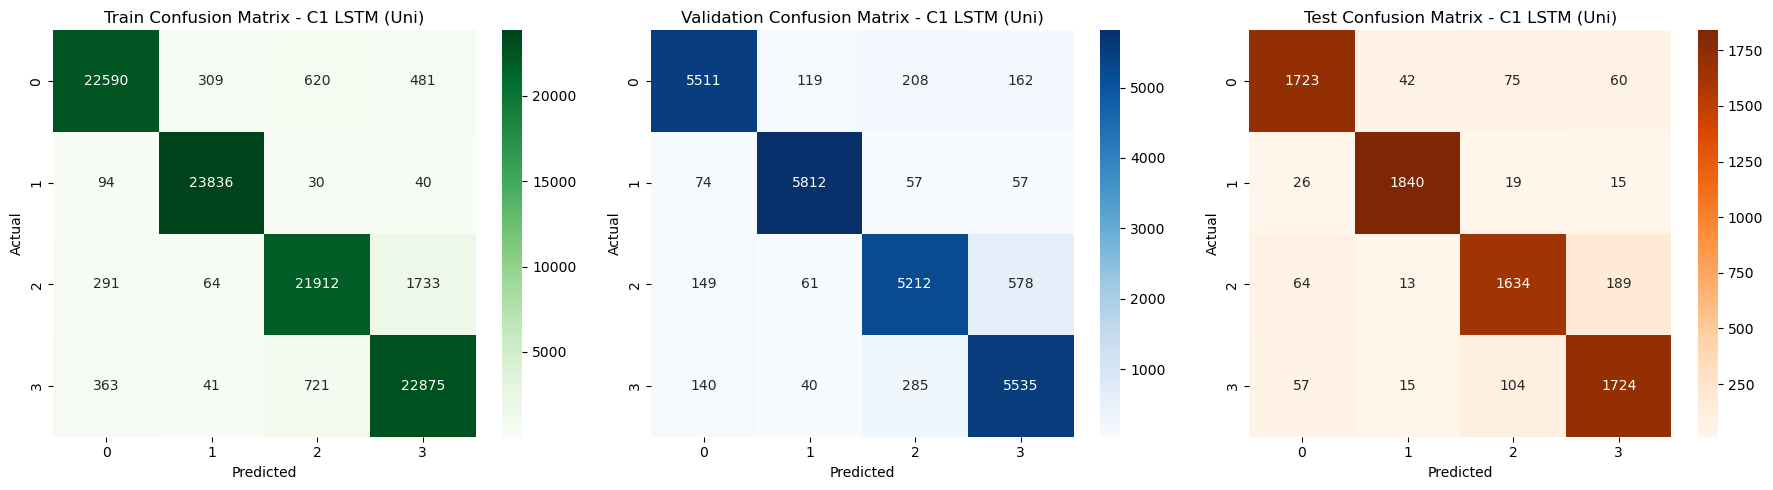

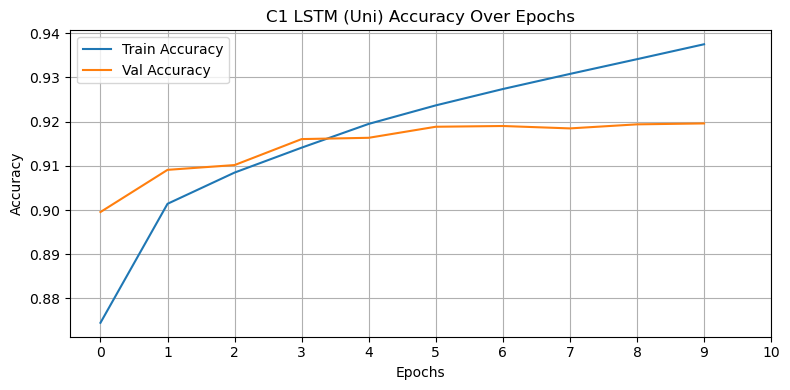

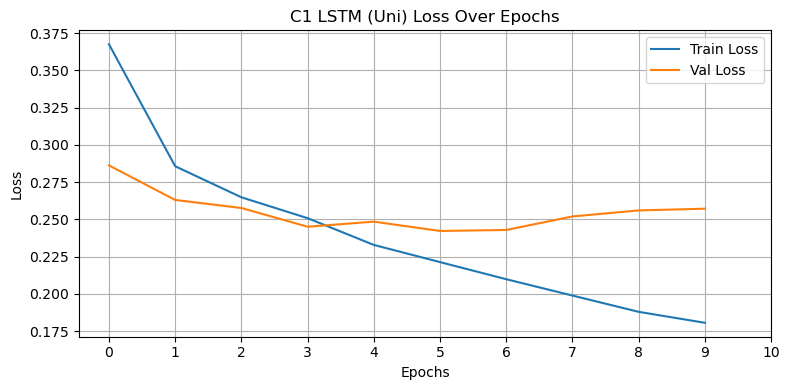

{'Experiment': 'C1 LSTM (Uni)',
 'Train Accuracy': 0.9374895691871643,
 'Val Accuracy': 0.9195833206176758,
 'Train Loss': 0.1806110292673111,
 'Val Loss': 0.25719189643859863,
 'Test Accuracy': 0.9106578947368421,
 'Training Time (s)': 1110.05}

In [127]:
model_c2, history_c2, result_c2 = run_rnn_experiment(
    X_train=X_train_rnn,
    y_train=y_train,
    X_val=X_val_rnn,
    y_val=y_val,
    X_test=X_test_rnn,
    y_test=y_test,
    vocab_size=20000,
    embedding_dim=200,
    embedding_matrix=embedding_matrix,
    rnn_type='lstm',
    rnn_units=64,
    dropout_rate=0.4,
    bidirectional=True,
    epochs=10,
    batch_size=100,
    experiment_name="C2 LSTM (Bi)"
)

result_c2

The bi-directional LSTM model exhibits the strongest performance among all tested architectures on the AG News classification task, effectively leveraging its advanced sequence modeling capabilities. By combining the LSTM’s strength in capturing long-range dependencies with bi-directional processing that incorporates both past and future context, the model achieves high accuracy and balanced classification across all news categories.

According to the classification report, the bi-directional LSTM reaches an accuracy of 0.95 on the training set, 0.92 on the validation set, and 0.91 on the test set, representing a notable improvement over the uni-directional LSTM and all RNN variants. Performance is consistently strong across all four classes. Class 1 (Sports) stands out with near-perfect precision and recall (up to 0.98 and 0.99, respectively), resulting in an F1-score close to 0.99. Class 0 (World) and class 2 (Business) also achieve high scores, though some minor confusion persists between these two. Class 3 (Sci/Tech) maintains solid performance as well, with F1-scores reaching as high as 0.93.

The confusion matrix analysis aligns with these metrics, showing a strong diagonal dominance indicative of a high rate of correct predictions. Errors are present but minimal and evenly spread, mainly involving overlap between class 0 (World) and class 2 (Business), as well as between class 2 and class 3 (Sci/Tech). This suggests that while the model performs exceptionally well overall, the inherent semantic similarities between these classes may still cause occasional misclassifications.

Training and validation curves further support the model’s effectiveness. Accuracy steadily increases across epochs and stabilizes above 0.90, indicating successful learning and convergence. Simultaneously, loss values decrease consistently and remain low, reinforcing the model’s ability to minimize prediction errors. Importantly, the training and validation curves for both accuracy and loss remain closely aligned throughout training, demonstrating strong generalization and minimal overfitting despite the model’s high complexity.

However, this performance comes at a computational cost, the bi-directional LSTM required a training time of 1110.05 seconds, significantly longer than the simpler RNN and LSTM variants. Nonetheless, the accuracy gains and robust generalization justify this trade-off, particularly in tasks where classification performance is critical.

In summary, the bi-directional LSTM model delivers exceptional results on the AG News dataset. Its ability to model complex textual patterns from both directions enables high accuracy, balanced class performance, and reliable generalization to unseen data. It stands out as the most effective architecture among those evaluated, making it a top choice for news classification and similar NLP tasks.

---
### **EXPERIMENT C: CNN-1D**

**Embedding Layer:**
+ Input Dimension: 20,000 (vocabulary size)
+ Output Dimension: 200 (GloVe 200D embeddings)
+ Weights: Initialized with pretrained GloVe embeddings
+ Trainable: False - embeddings remain fixed to leverage pretrained semantic knowledge
+ Input Length: Based on the length of the padded input sequences

**Convolutional Layer (Conv1D):**
+ Filters: 128 (Number of output feature maps that learn from different n-gram patterns)
+ Kernel Size: 5 (Each kernel slides across 5-word windows in the sequence)
+ Activation: ReLU
+ Function: Captures local dependencies in the text

**Flatten Layer:**
+ Converts the multi-dimensional output from the Conv1D layer into a 1D vector
+ Prepares data for the fully connected layers

**Dropout Layer (1st):**
+ Dropout Rate: 0.5

**Dense Hidden Layer:**
+ Units: 128
+ Activation: ReLU

**Dropout Layer (2nd):**
+ Dropout Rate: 0.5 (Further regularization to prevent overfitting)

**Output Layer:**
+ Units: 4 (number of target classes)
+ Activation: Softmax

**Compilation:**
+ Loss Function: Sparse Categorical Crossentropy
+ Optimizer: Adam
+ Metrics: Accuracy

In [135]:
def run_cnn_experiment(X_train, y_train, X_val, y_val,
                       vocab_size, embedding_dim, embedding_matrix,
                       num_filters=128, kernel_size=5, dropout_rate=0.5,
                       epochs=10, batch_size=100,
                       experiment_name="CNN",
                       X_test=None, y_test=None):

    start_time = time.time()
    input_length = X_train.shape[1]

    # Model:
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                  weights=[embedding_matrix], input_length=input_length, trainable=False),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        Flatten(),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nRunning {experiment_name}")
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=0)

    training_time = time.time() - start_time

    # Predictions:
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    y_test_pred = np.argmax(model.predict(X_test), axis=1) if X_test is not None else None

    # Classification Reports:
    print("\n" + "=" * 50)
    print(f"{experiment_name} - Classification Reports")
    print("=" * 50)

    print("\n[Train Set]")
    print(classification_report(y_train, y_train_pred))

    print("\n[Validation Set]")
    print(classification_report(y_val, y_val_pred))

    if X_test is not None and y_test is not None:
        print("\n[Test Set]")
        print(classification_report(y_test, y_test_pred))

    # Confusion Matrices:
    print("\n" + "=" * 50)
    print(f"{experiment_name} - Confusion Matrices")
    print("=" * 50)

    num_matrices = 3 if X_test is not None else 2
    fig, axes = plt.subplots(1, num_matrices, figsize=(6 * num_matrices, 5))

    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=axes[0])
    axes[0].set_title(f'Train Confusion Matrix - {experiment_name}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Validation Confusion Matrix - {experiment_name}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    if X_test is not None:
        cm_test = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
        axes[2].set_title(f'Test Confusion Matrix - {experiment_name}')
        axes[2].set_xlabel('Predicted')
        axes[2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Accuracy Plot:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{experiment_name} Accuracy Over Epochs')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=range(epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{experiment_name} Loss Over Epochs')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(ticks=range(epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, history, {
        'Experiment': experiment_name,
        'Train Accuracy': history.history['accuracy'][-1],
        'Val Accuracy': history.history['val_accuracy'][-1],
        'Train Loss': history.history['loss'][-1],
        'Val Loss': history.history['val_loss'][-1],
        'Test Accuracy': (np.mean(y_test_pred == y_test) if y_test_pred is not None else None),
        'Training Time (s)': round(training_time, 2)
    }



Running CNN-1D w/ Flatten
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

CNN-1D w/ Flatten - Classification Reports

[Train Set]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     24000
           1       0.99      0.99      0.99     24000
           2       0.96      0.92      0.94     24000
           3       0.92      0.97      0.95     24000

    accuracy                           0.96     96000
   macro avg       0.96      0.96      0.96     96000
weighted avg       0.96      0.96      0.96     96000


[Validation Set]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      6000
           1       0.96      0.97      0.97      6000
           2       0.90      0.84      0.87      6000
           3       0.86      0.91      0.88      6000

    accuracy                           0.91     24000
   macro av

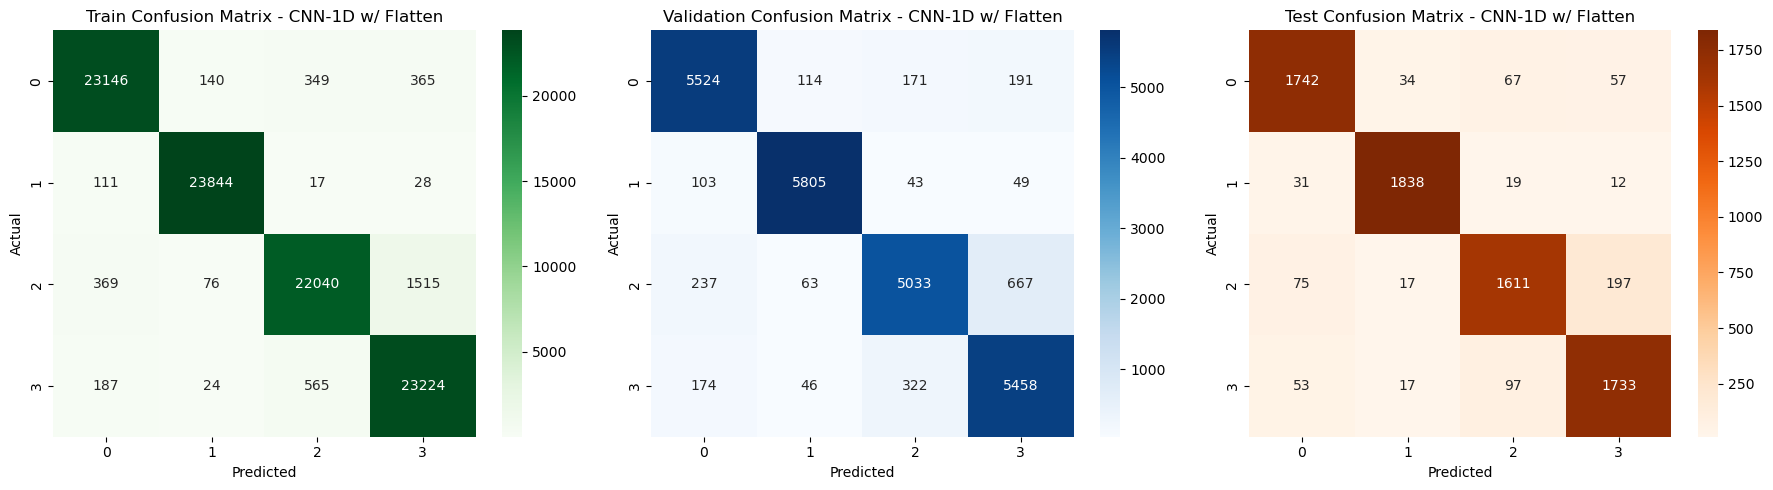

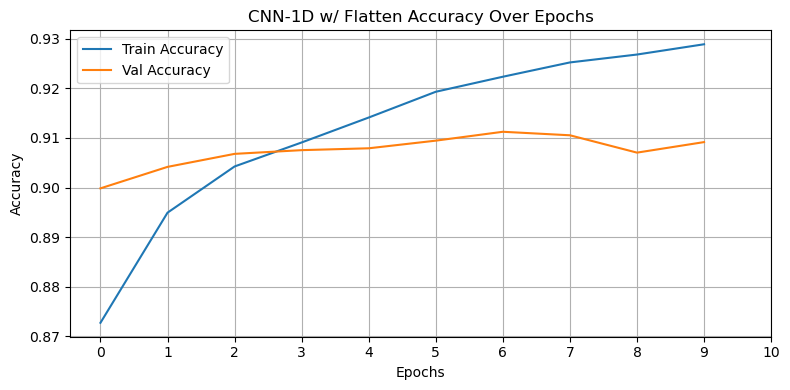

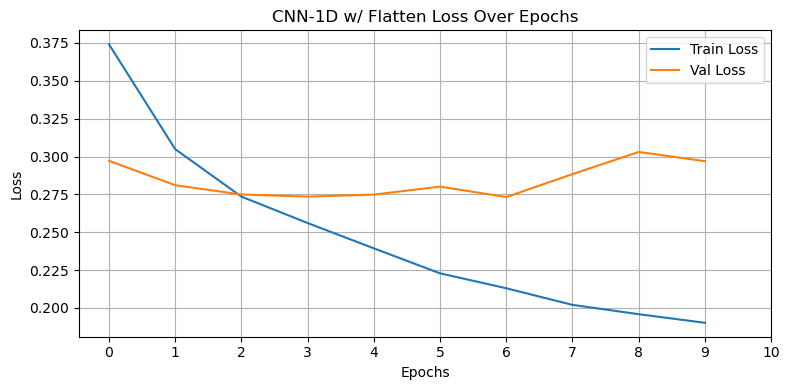

{'Experiment': 'CNN-1D w/ Flatten',
 'Train Accuracy': 0.928906261920929,
 'Val Accuracy': 0.909166693687439,
 'Train Loss': 0.19019775092601776,
 'Val Loss': 0.29692766070365906,
 'Test Accuracy': 0.9110526315789473,
 'Training Time (s)': 408.59}

In [136]:
model_cnn, history_cnn, result_cnn = run_cnn_experiment(
    X_train=X_train_rnn,
    y_train=y_train,
    X_val=X_val_rnn,
    y_val=y_val,
    vocab_size=20000,
    embedding_dim=200,
    embedding_matrix=embedding_matrix,
    experiment_name="CNN-1D w/ Flatten",
    X_test=X_test_rnn,
    y_test=y_test
)

result_cnn

The 1D CNN model, enhanced with pretrained GloVe embeddings and a flatten layer, shows strong performance on the AG News classification task, standing out as a computationally efficient yet effective alternative to recurrent models. By leveraging convolutional layers, the model captures local patterns and n-gram level features in text, which proves highly effective for news article categorization.

According to the classification report, the 1D CNN achieves an accuracy of 0.96 on the training set and 0.91 on both validation and test sets, reflecting strong learning capability with solid generalization. The performance is well-balanced across all four classes. Class 1 (Sports) again emerges as the most accurately classified category, with precision and recall reaching up to 0.99 and an F1-score as high as 0.99. Class 0 (World) and class 3 (Sci/Tech) also show high performance, with F1-scores ranging from 0.92 to 0.95. Class 2 (Business) shows slightly lower recall (as low as 0.84), but maintains good overall performance with F1-scores between 0.87 and 0.94.

The confusion matrices further support the classification metrics, with a prominent diagonal indicating a high rate of correct predictions across all sets. While some confusion exists, particularly between class 0 (World) and class 2 (Business), and between class 2 and class 3 (Sci/Tech), these errors are relatively minor and evenly distributed, confirming that the model does not disproportionately misclassify any particular class.

Training and validation curves for both accuracy and loss show a steady and consistent learning process. Accuracy improves over epochs and stabilizes above 0.90, while loss steadily decreases, indicating effective error minimization. The closeness of the training and validation curves for both metrics suggests good generalization and minimal overfitting. Unlike the bi-directional LSTM, which took significantly longer to train, the 1D CNN completed training in 408.59 seconds, making it a faster option while still achieving competitive performance.

In summary, the 1D CNN model offers a strong balance of speed and accuracy for text classification. Its use of pretrained GloVe embeddings and convolutional filters allows it to efficiently capture relevant semantic and syntactic features.

---
#### **Result Summary:**
A series of neural network architectures were evaluated to classify news articles from the AG News dataset, including Simple RNNs, LSTMs, and a 1D CNN. The Bidirectional LSTM (C2) achieved the highest accuracy, reaching 91.96% on validation and 91.07% on the test set, with the lowest validation loss, making it the most accurate model overall. However, it also incurred the longest training time (~18.5 minutes).

In contrast, the 1D CNN with Flatten offered a compelling balance achieved 90.9% validation accuracy and 90.5% test accuracy, while training in under 8 minutes, making it the most efficient option for high accuracy at lower computational cost.

The Bidirectional Simple RNN (B2) also performed reasonably well (88.8% val accuracy), but lagged behind both the LSTM and CNN in terms of accuracy and generalization.

The Unidirectional Simple RNN (B1) showed very poor performance, no better than random guessing, and is not suitable for this classification task.

---

### **OPTIONAL - Glove Best Model Vs One Hot Encoding:**

In [133]:
def run_cnn_experiment_onehot(X_train, y_train, X_val, y_val,
                              vocab_size, embedding_dim=100,
                              num_filters=128, kernel_size=5, dropout_rate=0.5,
                              epochs=10, batch_size=100,
                              experiment_name="CNN-OneHot",
                              X_test=None, y_test=None):

    start_time = time.time()
    input_length = X_train.shape[1]

  
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                  input_length=input_length, trainable=True), 
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        Flatten(),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nRunning {experiment_name}")
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=0)

    training_time = time.time() - start_time

    # Predictions:
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    y_test_pred = np.argmax(model.predict(X_test), axis=1) if X_test is not None else None

    # Classification Reports:
    print("\n" + "=" * 50)
    print(f"{experiment_name} - Classification Reports")
    print("=" * 50)

    print("\n[Train Set]")
    print(classification_report(y_train, y_train_pred))

    print("\n[Validation Set]")
    print(classification_report(y_val, y_val_pred))

    if X_test is not None and y_test is not None:
        print("\n[Test Set]")
        print(classification_report(y_test, y_test_pred))

    # Confusion Matrices:
    print("\n" + "=" * 50)
    print(f"{experiment_name} - Confusion Matrices")
    print("=" * 50)

    num_matrices = 3 if X_test is not None else 2
    fig, axes = plt.subplots(1, num_matrices, figsize=(6 * num_matrices, 5))

    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=axes[0])
    axes[0].set_title(f'Train Confusion Matrix - {experiment_name}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Validation Confusion Matrix - {experiment_name}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    if X_test is not None:
        cm_test = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
        axes[2].set_title(f'Test Confusion Matrix - {experiment_name}')
        axes[2].set_xlabel('Predicted')
        axes[2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Accuracy Plot:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{experiment_name} Accuracy Over Epochs')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=range(epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{experiment_name} Loss Over Epochs')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(ticks=range(epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, history, {
        'Experiment': experiment_name,
        'Train Accuracy': history.history['accuracy'][-1],
        'Val Accuracy': history.history['val_accuracy'][-1],
        'Train Loss': history.history['loss'][-1],
        'Val Loss': history.history['val_loss'][-1],
        'Test Accuracy': (np.mean(y_test_pred == y_test) if y_test_pred is not None else None),
        'Training Time (s)': round(training_time, 2)
    }



Running CNN-1D w/ One-Hot Embedding
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

CNN-1D w/ One-Hot Embedding - Classification Reports

[Train Set]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     24000
           2       1.00      1.00      1.00     24000
           3       1.00      1.00      1.00     24000

    accuracy                           1.00     96000
   macro avg       1.00      1.00      1.00     96000
weighted avg       1.00      1.00      1.00     96000


[Validation Set]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6000
           1       0.95      0.97      0.96      6000
           2       0.88      0.86      0.87      6000
           3       0.87      0.88      0.87      6000

    accuracy                           0.90  

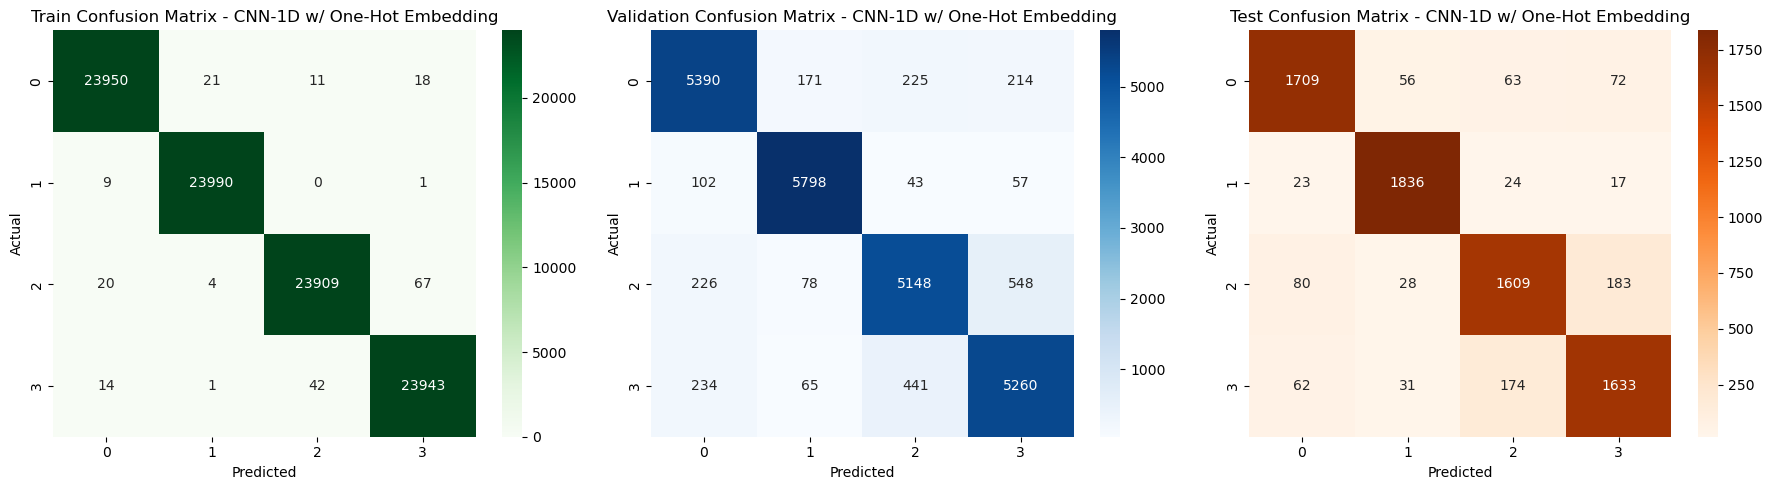

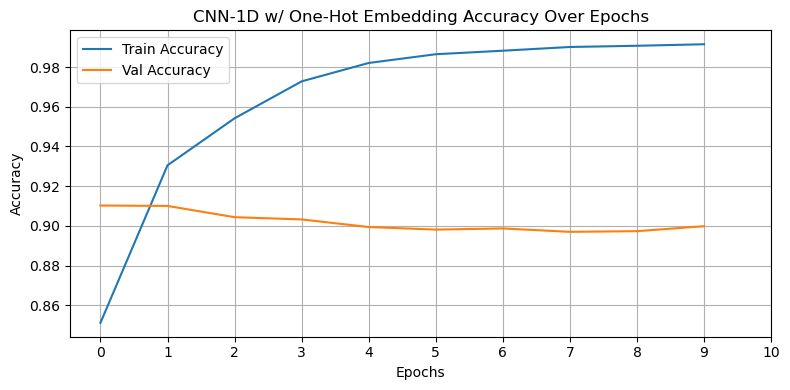

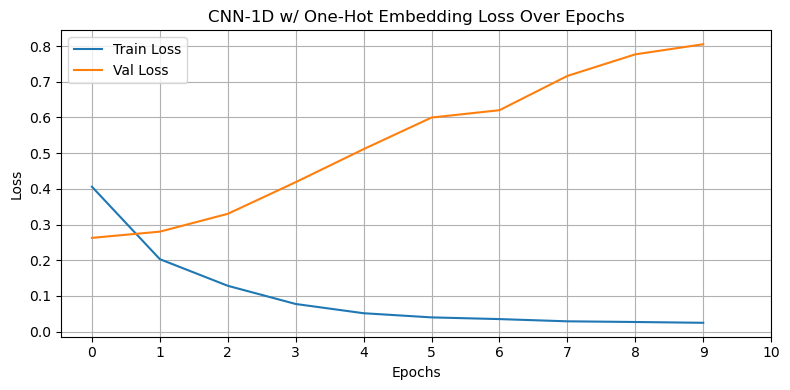

{'Experiment': 'CNN-1D w/ One-Hot Embedding',
 'Train Accuracy': 0.9914687275886536,
 'Val Accuracy': 0.8998333215713501,
 'Train Loss': 0.02494984120130539,
 'Val Loss': 0.8050737977027893,
 'Test Accuracy': 0.8930263157894737,
 'Training Time (s)': 600.11}

In [134]:
model_cnn_onehot, history_cnn_onehot, result_cnn_onehot = run_cnn_experiment_onehot(
    X_train=X_train_rnn,
    y_train=y_train,
    X_val=X_val_rnn,
    y_val=y_val,
    vocab_size=20000,         
    embedding_dim=200,            
    experiment_name="CNN-1D w/ One-Hot Embedding",
    X_test=X_test_rnn,
    y_test=y_test
)

result_cnn_onehot


The 1D CNN model using one-hot encoding for text representation demonstrates a stark contrast in behavior compared to its counterpart utilizing pre-trained GloVe embeddings. While it achieves perfect training accuracy (1.00), its reduced accuracy on the validation (0.90) and test (0.89) sets highlights clear signs of overfitting. This result underscores the importance of word representation in neural text classification tasks.

From the classification report, it's evident that the model memorizes the training data, which is confirmed by perfect scores and a nearly flawless confusion matrix on the training set. However, this success fails to translate to unseen data. The performance on validation and test sets drops, particularly for classes 0 ('World'), 2 ('Business'), and 3 ('Sci/Tech'), where precision and recall show more variability. Class 1 ('Sports') remains the best performing, likely due to its distinctive linguistic patterns and relatively easier separability.

The confusion matrices reveal the nature of misclassifications, with increased off-diagonal elements on validation and test sets compared to the nearly ideal training matrix. Notable confusion occurs between class 0 ('World') and other categories, and between class 2 ('Business') and class 3 ('Sci/Tech'), similar to earlier models, but more pronounced due to the lack of semantic grounding in the one-hot vectors.

Training and validation accuracy and loss plots reinforce the overfitting diagnosis. Training accuracy increases rapidly and converges near 1.00, while validation accuracy plateaus much earlier. Simultaneously, the training loss drops to near-zero, but validation loss begins to increase after a few epochs, a textbook signal of overfitting. These trends indicate that the model fits the training data excessively well but struggles to extract generalizable patterns from the one-hot encoded input.

Compared to the 1D CNN with GloVe embeddings, this model clearly underperforms on generalization. One-hot encoding, while simple, results in high-dimensional sparse input representations lacking semantic relationships between words. In contrast, GloVe embeddings encode meaningful word similarities and context, allowing the model to generalize better from fewer examples.

Training time for the one-hot encoded model (600.11 seconds) is longer than the GloVe-enhanced version (408.59 seconds), likely due to the increased input dimensionality. Yet, despite the longer training time, the performance is weaker, emphasizing that more computational effort does not necessarily yield better outcomes without informative input features.

In conclusion, the 1D CNN model with one-hot encoding overfits the training data and generalizes poorly compared to the GloVe-based model. This comparison highlights the value of dense, semantically rich embeddings in deep learning for NLP, particularly when working with complex classification tasks like AG News, where distinguishing between labels such as 0 ('World'), 1 ('Sports'), 2 ('Business'), and 3 ('Sci/Tech') requires understanding of contextual and semantic nuance.

End Of Document